In [369]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic
from itertools import permutations
import folium
from IPython.display import display
import requests
import time
import numpy as np
from functools import lru_cache
from datetime import datetime, timedelta, time
import random
from typing import Dict, List, Tuple, Optional
import json
from dataclasses import dataclass
import copy
import matplotlib.pyplot as plt
import numpy.typing as npt
from dataclasses import dataclass
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

In [311]:
OSRM_SERVER = "http://router.project-osrm.org"  # Free OSRM server
REQUEST_DELAY = 0.1  # Delay between requests to avoid rate limiting

### These are the control variables - I have taken fair bit of assumption but these can be easily estimated from national average , or if we split demographically they provide much better modelling

In [312]:
n = 10              # total debtors
p = 1                # number of clusters
v = 0.01             # coordinate variance for clusters
e = 2               # number of employees
avg_exp = 2          # average experience (years)
avg_exp_var = 3      # variance in experience
speed_kmh = 25.0     # average travel speed to convert km -> hours (time = dist / speed_kmh)
max_2opt_iters = 200 # max iterations of 2-opt per route

# Cluster centers (Delhi regions)
cluster_centers = [
    (28.6315, 77.2167)  # Connaught Place
    # (28.5672, 77.2433),  # Lajpat Nagar
    # (28.7490, 77.0560),  # Rohini
    # (28.5921, 77.0460)   # Dwarka
]

# Cluster-level economic variations
cluster_avg_owed = [50000, 70000, 30000, 45000]  
cluster_var_owed = [10000, 15000, 8000, 12000]

### Creating a distribution of debtors

In [313]:
def generate_debtors(n, p, v, centers, avg_list, var_list):
    debtors = []
    cluster_size = n // p
    
    for i in range(p):
        lat_center, lon_center = centers[i]
        latitudes = np.random.normal(lat_center, v, cluster_size)
        longitudes = np.random.normal(lon_center, v, cluster_size)
        owed_amounts = np.random.normal(avg_list[i], var_list[i], cluster_size).clip(min=100)
        
        for j in range(cluster_size):
            debtors.append({
                "debtor_id": f"D{i}_{j}",  # Added unique ID
                "cluster": i,
                "latitude": latitudes[j],
                "longitude": longitudes[j],
                "money_owed": round(owed_amounts[j], 2)
            })
    
    # handle remainder if n not divisible by p
    while len(debtors) < n:
        idx = len(debtors)
        debtors.append({
            "debtor_id": f"D{p-1}_extra_{idx}",  # Added unique ID
            "cluster": p-1,
            "latitude": np.random.normal(centers[-1][0], v),
            "longitude": np.random.normal(centers[-1][1], v),
            "money_owed": round(max(100, np.random.normal(avg_list[-1], var_list[-1])), 2)
        })
    
    return pd.DataFrame(debtors)

### Simply plotting them 


In [314]:
debtors_df = generate_debtors(n, p, v, cluster_centers, cluster_avg_owed, cluster_var_owed)
debtors_df.head()

# Cell 5
def plot_clusters_map(df, centers):
    delhi_map = folium.Map(location=[28.6139, 77.2090], zoom_start=11)
    colors = ["blue", "green", "purple", "orange", "darkred", "cadetblue"]

    # Add debtors
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=(row["latitude"], row["longitude"]),
            radius=max(3, row["money_owed"] / 2000),
            color=colors[int(row["cluster"]) % len(colors)],
            fill=True,
            fill_opacity=0.6,
            popup=f"ID: {row.get('debtor_id', 'N/A')}<br>Cluster: {row['cluster']}<br>Owed: ₹{row['money_owed']}"
        ).add_to(delhi_map)

    # Add cluster centers
    for i, (lat, lon) in enumerate(centers):
        folium.Marker(
            location=(lat, lon),
            popup=f"Cluster Center {i}",
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(delhi_map)

    return delhi_map

In [315]:
m = plot_clusters_map(debtors_df, cluster_centers)
display(m)


### Assumption - Employees close to a cluster's center will be assigned that individual cluster for operations

In [316]:
def generate_employees(e, centers, v, avg_exp, avg_exp_var):
    employees = []
    cluster_size = max(1, e // len(centers))  # employees per cluster

    emp_id = 0
    for i, (lat_center, lon_center) in enumerate(centers):
        for j in range(cluster_size):
            exp = np.random.normal(avg_exp, avg_exp_var)
            employees.append({
                "employee_id": f"E{emp_id}",
                "cluster": i,
                "latitude": np.random.normal(lat_center, v/2),   # closer than debtors
                "longitude": np.random.normal(lon_center, v/2),
                "experience": round(max(0.1, exp), 2)  # no negative exp, min 0.1
            })
            emp_id += 1

    # handle remainder if e not divisible by clusters
    while len(employees) < e:
        employees.append({
            "employee_id": f"E{emp_id}",
            "cluster": len(centers)-1,
            "latitude": np.random.normal(centers[-1][0], v/2),
            "longitude": np.random.normal(centers[-1][1], v/2),
            "experience": round(max(0.1, np.random.normal(avg_exp, avg_exp_var)), 2)
        })
        emp_id += 1

    return pd.DataFrame(employees)

# Generate employees
employees_df = generate_employees(e, cluster_centers, v, avg_exp, avg_exp_var)
employees_df.head()

,employee_id,cluster,latitude,longitude,experience
0,E0,0,28.637371,77.212222,3.36
1,E1,0,28.627333,77.223741,5.34


In [317]:
employees_df = generate_employees(e, cluster_centers, v, avg_exp, avg_exp_var)
employees_df.head()

,employee_id,cluster,latitude,longitude,experience
0,E0,0,28.634667,77.214046,0.10
1,E1,0,28.630181,77.204117,1.46


### IDK what was i thinking - pairs up employees and they start the journey from the location of senior employee

In [318]:
def pair_employees(employees_df):
    new_joiners = employees_df[employees_df["experience"] < 1].copy()
    seniors = employees_df[employees_df["experience"] > 2].copy()

    pairs = []
    used_seniors = set()

    for _, nj in new_joiners.iterrows():
        available_seniors = seniors[~seniors["employee_id"].isin(used_seniors)]
        if not available_seniors.empty:
            # pick the closest senior from the same cluster if possible
            same_cluster_seniors = available_seniors[available_seniors["cluster"] == nj["cluster"]]
            if not same_cluster_seniors.empty:
                senior = same_cluster_seniors.iloc[0]  # Fixed: use iloc[0] instead of sample
            else:
                senior = available_seniors.iloc[0]  # Fixed: use iloc[0] instead of sample

            pairs.append({
                "new_joiner": nj["employee_id"],
                "senior": senior["employee_id"],
                "cluster": senior["cluster"]  # Added cluster info
            })

            used_seniors.add(senior["employee_id"])

    return pd.DataFrame(pairs)

pairs_df = pair_employees(employees_df)
pairs_df.head()

""


In [319]:
employees_df.to_csv("employees.csv", index=False)
pairs_df.to_csv("employee_pairs.csv", index=False)
debtors_df.to_csv("debtors.csv", index=False)  # Added debtors save

print("✅ employees.csv, employee_pairs.csv, and debtors.csv generated")


✅ employees.csv, employee_pairs.csv, and debtors.csv generated


### First Prototype model used Haversine Distance (fancy cartesian distance for curved objects)

In [320]:
def haversine_km(a, b):
    """Wrapper using geodesic for robust distance (km)."""
    return geodesic(a, b).km

def time_from_km(km, speed_kmh=speed_kmh):
    return km / speed_kmh

### Generate a matrix for distance between the nodes 

In [321]:
def build_matrix(start_coord, debtor_coords):
    """
    Build symmetric distance (km) and time (hrs) matrices for points:
    index 0 = start, indices 1..N = debtors in given order.
    """
    pts = [start_coord] + debtor_coords
    n = len(pts)
    dist = np.zeros((n, n))
    time = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = haversine_km(pts[i], pts[j])
            dist[i, j] = dist[j, i] = d
            t = time_from_km(d)
            time[i, j] = time[j, i] = t
    return dist, time

In [322]:
def nearest_neighbor_route(time_mat):
    """
    Nearest Neighbor starting from index 0 (start). Returns route as list of indices.
    time_mat is NxN where index 0 is start.
    """
    n = time_mat.shape[0]
    if n <= 1:
        return [0] if n == 1 else []
    
    unvisited = set(range(1, n))
    route = [0]
    current = 0
    while unvisited:
        next_node = min(unvisited, key=lambda x: time_mat[current, x])
        route.append(next_node)
        unvisited.remove(next_node)
        current = next_node
    return route

def route_total(time_mat, route):
    """Total time (hrs) along route (no return to start)."""
    if len(route) < 2:
        return 0.0
    total = 0.0
    for i in range(len(route)-1):
        total += time_mat[route[i], route[i+1]]
    return total

In [323]:
def two_opt(route, time_mat, max_iters=200):
    """
    2-opt improvement on given route (list of indices). Keeps start (index 0) fixed.
    Returns improved route and its time.
    """
    if len(route) < 4:  # Need at least 4 points for meaningful 2-opt
        return route, route_total(time_mat, route)
    
    best_route = route.copy()
    best_cost = route_total(time_mat, best_route)
    n = len(best_route)
    iters = 0
    improved = True

    while improved and iters < max_iters:
        improved = False
        iters += 1
        # don't touch index 0 (start), so i from 1 to n-3, j from i+1 to n-1
        for i in range(1, n - 2):
            for j in range(i + 1, n):
                if j - i <= 1:  # Fixed condition
                    continue
                # create new route by reversing segment i..j
                new_route = best_route[:i] + best_route[i:j+1][::-1] + best_route[j+1:]
                new_cost = route_total(time_mat, new_route)
                if new_cost < best_cost - 1e-9:  # Fixed comparison
                    best_route = new_route
                    best_cost = new_cost
                    improved = True
                    break
            if improved:
                break
    return best_route, best_cost

In [324]:
def solve_pair_route(start_coord, debtors_df_for_pair, speed_kmh=speed_kmh, max_2opt_iters=max_2opt_iters):
    """
    start_coord: (lat, lon)
    debtors_df_for_pair: DataFrame with columns ['latitude','longitude','money_owed', ...]
      order in route corresponds to indices 1..N in matrix
    Returns:
      - ordered dataframe of visited debtors with per-leg dist/time
      - total_distance_km, total_time_hr
      - list of visited indices mapping to debtors_df_for_pair rows (in order)
    """
    if len(debtors_df_for_pair) == 0:
        return pd.DataFrame(), 0.0, 0.0, []
    
    debtor_coords = list(zip(debtors_df_for_pair['latitude'].values, debtors_df_for_pair['longitude'].values))

    # Build matrices
    dist_mat, time_mat = build_matrix(start_coord, debtor_coords)

    # initial route (0=start, then debtors 1..N)
    init_route = nearest_neighbor_route(time_mat)
    # improve with 2-opt
    best_route, best_time = two_opt(init_route, time_mat, max_iters=max_2opt_iters)

    # compute per-leg distances/times and assemble ordered dataframe
    ordered_rows = []
    total_dist = 0.0
    total_time = 0.0
    
    for i in range(len(best_route)-1):
        u = best_route[i]
        v = best_route[i+1]
        leg_dist = dist_mat[u, v]
        leg_time = time_mat[u, v]
        total_dist += leg_dist
        total_time += leg_time
        
        if v != 0:  # Skip if returning to start
            debtor_idx = v - 1  # because debtors are indices 1..N in matrix
            row = dict(debtors_df_for_pair.iloc[debtor_idx])
            row.update({
                'visit_order': len(ordered_rows) + 1,
                'leg_dist_km': round(leg_dist, 4),
                'leg_time_hr': round(leg_time, 6)
            })
            ordered_rows.append(row)

    ordered_df = pd.DataFrame(ordered_rows)
    return ordered_df, round(total_dist, 4), round(total_time, 6), best_route


In [325]:
def assign_debtors_to_pairs(debtors_df, employees_df, pairs_df):
    assignments = []

    for _, pair in pairs_df.iterrows():
        senior = employees_df[employees_df["employee_id"] == pair["senior"]].iloc[0]
        cluster = senior["cluster"]

        cluster_debtors = debtors_df[debtors_df["cluster"] == cluster].copy()
        cluster_debtors = cluster_debtors.sort_values("money_owed", ascending=False)

        assignments.append({
            "pair": (pair["new_joiner"], pair["senior"]),
            "cluster": cluster,  # Added cluster info
            "start_location": (senior["latitude"], senior["longitude"]),
            "cluster_debtors": cluster_debtors
        })

    return assignments

assignments = assign_debtors_to_pairs(debtors_df, employees_df, pairs_df)


### Decided to use Actual distance used data from free ORSM API 

In [326]:
@lru_cache(maxsize=1000)  # Cache results to avoid repeated API calls
def get_road_distance_time(coord1, coord2):
    """
    Get actual road distance and travel time between two coordinates using OSRM.
    
    Args:
        coord1: tuple (lat, lon)
        coord2: tuple (lat, lon)
    
    Returns:
        tuple (distance_km, time_hours)
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    # If coordinates are identical, return zero
    if abs(lat1 - lat2) < 1e-6 and abs(lon1 - lon2) < 1e-6:
        return 0.0, 0.0
    
    try:
        # OSRM expects lon,lat format
        url = f"{OSRM_SERVER}/route/v1/driving/{lon1},{lat1};{lon2},{lat2}"
        params = {
            'overview': 'false',  # We don't need the geometry
            'steps': 'false'      # We don't need turn-by-turn directions
        }
        
        response = requests.get(url, params=params, timeout=10)
        time.sleep(REQUEST_DELAY)  # Rate limiting
        
        if response.status_code == 200:
            data = response.json()
            if data['code'] == 'Ok' and len(data['routes']) > 0:
                route = data['routes'][0]
                distance_m = route['distance']  # meters
                duration_s = route['duration']  # seconds
                
                distance_km = distance_m / 1000.0
                time_hours = duration_s / 3600.0
                
                return distance_km, time_hours
        
        # Fallback to geodesic if API fails
        print(f"Warning: OSRM API failed for {coord1} -> {coord2}, using geodesic fallback")
        return geodesic_fallback(coord1, coord2)
        
    except Exception as e:
        print(f"Error calling OSRM API: {e}, using geodesic fallback")
        return geodesic_fallback(coord1, coord2)

def geodesic_fallback(coord1, coord2):
    """Fallback to geodesic distance when API fails"""
    from geopy.distance import geodesic
    dist_km = geodesic(coord1, coord2).km
    # Estimate time assuming average speed (with road factor ~1.3x for non-straight roads)
    time_hours = (dist_km * 1.3) / speed_kmh
    return dist_km * 1.3, time_hours

def build_matrix_with_roads(start_coord, debtor_coords):
    """
    Build symmetric distance (km) and time (hrs) matrices using real road data.
    index 0 = start, indices 1..N = debtors in given order.
    """
    pts = [start_coord] + debtor_coords
    n = len(pts)
    dist = np.zeros((n, n))
    time_mat = np.zeros((n, n))
    
    print(f"Building road-based distance matrix for {n} points...")
    
    total_requests = (n * (n - 1)) // 2  # Number of unique pairs
    completed = 0
    
    for i in range(n):
        for j in range(i+1, n):
            d_km, t_hr = get_road_distance_time(pts[i], pts[j])
            dist[i, j] = dist[j, i] = d_km
            time_mat[i, j] = time_mat[j, i] = t_hr
            
            completed += 1
            if completed % 10 == 0:  # Progress indicator
                print(f"Progress: {completed}/{total_requests} distance calculations completed")
    
    print(f"Distance matrix complete. Total API calls: {completed}")
    return dist, time_mat


dist_mat: npt.NDArray[np.float64]
def solve_pair_route_with_roads(start_coord, debtors_df_for_pair, max_2opt_iters=max_2opt_iters):
    """
    Modified version that uses real road data for routing.
    
    Args:
        start_coord: (lat, lon)
        debtors_df_for_pair: DataFrame with columns ['latitude','longitude','money_owed', ...]
        max_2opt_iters: maximum iterations for 2-opt optimization
    
    Returns:
        - ordered dataframe of visited debtors with per-leg dist/time
        - total_distance_km, total_time_hr
        - list of visited indices mapping to debtors_df_for_pair rows (in order)
    """
    if len(debtors_df_for_pair) == 0:
        return pd.DataFrame(), 0.0, 0.0, []
    
    debtor_coords = list(zip(debtors_df_for_pair['latitude'].values, debtors_df_for_pair['longitude'].values))

    # Build matrices using real road data
    print(f"Calculating road distances for pair starting at {start_coord}")
    global dist_mat
    dist_mat, time_mat = build_matrix_with_roads(start_coord, debtor_coords)
    print('hooooooo')
    print(dist_mat)
    # Initial route using nearest neighbor
    init_route = nearest_neighbor_route(time_mat)
    # Improve with 2-opt
    best_route, best_time = two_opt(init_route, time_mat, max_iters=max_2opt_iters)

    # Compute per-leg distances/times and assemble ordered dataframe
    ordered_rows = []
    total_dist = 0.0
    total_time = 0.0
    
    for i in range(len(best_route)-1):
        u = best_route[i]
        v = best_route[i+1]
        leg_dist = dist_mat[u, v]
        leg_time = time_mat[u, v]
        total_dist += leg_dist
        total_time += leg_time
        
        if v != 0:  # Skip if returning to start
            debtor_idx = v - 1  # because debtors are indices 1..N in matrix
            row = dict(debtors_df_for_pair.iloc[debtor_idx])
            row.update({
                'visit_order': len(ordered_rows) + 1,
                'leg_dist_km': round(leg_dist, 4),
                'leg_time_hr': round(leg_time, 6)
            })
            ordered_rows.append(row)

    ordered_df = pd.DataFrame(ordered_rows)
    return ordered_df, round(total_dist, 4), round(total_time, 6), best_route

# Alternative batch processing function for better API efficiency
def build_matrix_batch_osrm(start_coord, debtor_coords, batch_size=25):
    """
    More efficient matrix building using OSRM's table service (if available).
    Falls back to individual requests if table service fails.
    """
    pts = [start_coord] + debtor_coords
    n = len(pts)
    
    try:
        # Try using OSRM table service for better efficiency
        coords_str = ";".join([f"{lon},{lat}" for lat, lon in pts])
        url = f"{OSRM_SERVER}/table/v1/driving/{coords_str}"
        
        response = requests.get(url, timeout=30)
        
        if response.status_code == 200:
            data = response.json()
            if data['code'] == 'Ok':
                distances = np.array(data['distances']) / 1000.0  # Convert to km
                durations = np.array(data['durations']) / 3600.0  # Convert to hours
                
                print(f"Successfully used OSRM table service for {n} points")
                return distances, durations
    
    except Exception as e:
        print(f"OSRM table service failed: {e}, falling back to individual requests")
    
    # Fallback to individual requests
    return build_matrix_with_roads(start_coord, debtor_coords)

def get_route_geometry(coord1, coord2):
    """
    Get the actual road route geometry between two coordinates for plotting.
    
    Args:
        coord1: tuple (lat, lon)
        coord2: tuple (lat, lon)
    
    Returns:
        list of (lat, lon) tuples representing the route path
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    # If coordinates are identical, return direct line
    if abs(lat1 - lat2) < 1e-6 and abs(lon1 - lon2) < 1e-6:
        return [coord1, coord2]
    
    try:
        # OSRM expects lon,lat format
        url = f"{OSRM_SERVER}/route/v1/driving/{lon1},{lat1};{lon2},{lat2}"
        params = {
            'overview': 'full',    # Get full geometry
            'geometries': 'geojson'  # Return as GeoJSON
        }
        
        response = requests.get(url, params=params, timeout=10)
        time.sleep(REQUEST_DELAY)  # Rate limiting
        
        if response.status_code == 200:
            data = response.json()
            if data['code'] == 'Ok' and len(data['routes']) > 0:
                route = data['routes'][0]
                geometry = route['geometry']['coordinates']
                # Convert from [lon, lat] to [lat, lon]
                route_coords = [(lat, lon) for lon, lat in geometry]
                return route_coords
        
        # Fallback to straight line if API fails
        return [coord1, coord2]
        
    except Exception as e:
        print(f"Error getting route geometry: {e}, using straight line")
        return [coord1, coord2]

def plot_pair_route_on_map_with_roads(route_df, start_location, pair, cluster_id, zoom=12):
    """
    Enhanced plotting function that shows actual road routes instead of straight lines.
    """
    if route_df.empty:
        print(f"No route to display for pair {pair} - no debtors in cluster {cluster_id}")
        return None
    
    # Center map near start
    m = folium.Map(location=start_location, zoom_start=zoom)

    # Start marker (Senior)
    folium.Marker(
        location=start_location,
        popup=f"START: {pair[1]} (Senior)<br>Cluster: {cluster_id}",
        icon=folium.Icon(color="red", icon="star")
    ).add_to(m)

    # Build route segments with actual road geometry
    current_location = start_location
    total_road_distance = 0.0
    
    print(f"Plotting road routes for pair {pair}...")
    
    for idx, row in route_df.iterrows():
        next_location = (row['latitude'], row['longitude'])
        
        # Get actual road route geometry for this segment
        route_coords = get_route_geometry(current_location, next_location)
        
        # Add the road route as a polyline
        if len(route_coords) > 1:
            folium.PolyLine(
                route_coords, 
                color="blue", 
                weight=3, 
                opacity=0.7,
                popup=f"Segment {idx+1}: {row.get('leg_dist_km', 0):.2f} km"
            ).add_to(m)
        
        # Add debtor marker
        folium.CircleMarker(
            location=next_location,
            radius=max(4, min(12, (row.get('money_owed', 0) / 2000))),
            color='darkblue',
            fill=True,
            fillColor='lightblue',
            fill_opacity=0.7,
            popup=f"""
            <b>Visit #{int(row.get('visit_order', 0))}</b><br>
            ID: {row.get('debtor_id', 'N/A')}<br>
            Owes: ₹{row.get('money_owed', 0):,.2f}<br>
            Road Distance: {row.get('leg_dist_km', 0):.2f} km<br>
            Travel Time: {row.get('leg_time_hr', 0)*60:.1f} min
            """
        ).add_to(m)
        
        # Add visit order number
        folium.Marker(
            location=next_location,
            icon=folium.DivIcon(
                html=f'<div style="font-size: 10pt; color: white; font-weight: bold; text-align: center; background-color: darkblue; border-radius: 50%; width: 20px; height: 20px; line-height: 20px;">{int(row.get("visit_order", 0))}</div>',
                icon_size=(20, 20),
                icon_anchor=(10, 10)
            )
        ).add_to(m)
        
        current_location = next_location
        total_road_distance += row.get('leg_dist_km', 0)
    
    # Add a legend with route statistics
    legend_html = f"""
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 90px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <p><b>Route Statistics</b></p>
    <p>Total Road Distance: {total_road_distance:.2f} km</p>
    <p>Total Visits: {len(route_df)}</p>
    <p>Total Amount: ₹{route_df['money_owed'].sum():,.0f}</p>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

def plot_all_routes_combined_with_roads(all_routes, zoom=11):
    """
    Plot all routes on a single map using actual road data with different colors per pair.
    """
    if not all_routes:
        print("No routes to display")
        return None
    
    # Calculate map center from all start locations
    all_lats = [r['start_location'][0] for r in all_routes if not r["route_df"].empty]
    all_lons = [r['start_location'][1] for r in all_routes if not r["route_df"].empty]
    
    if not all_lats:
        print("No active routes to display")
        return None
    
    center_lat = sum(all_lats) / len(all_lats)
    center_lon = sum(all_lons) / len(all_lons)
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)
    
    # Color palette for different pairs
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'darkred', 'lightblue', 'darkgreen', 'cadetblue', 'pink']
    
    total_distance = 0.0
    total_debtors = 0
    
    print("Plotting combined road routes for all pairs...")
    
    for i, route_result in enumerate(all_routes):
        if route_result["route_df"].empty:
            continue
            
        color = colors[i % len(colors)]
        pair = route_result['pair']
        
        # Start marker
        folium.Marker(
            location=route_result['start_location'],
            popup=f"START: {pair[1]}<br>Pair: {pair}<br>Cluster: {route_result['cluster']}",
            icon=folium.Icon(color='red' if i == 0 else 'darkblue', icon="star")
        ).add_to(m)
        
        # Plot route with road geometry
        current_location = route_result['start_location']
        
        for idx, row in route_result["route_df"].iterrows():
            next_location = (row['latitude'], row['longitude'])
            
            # Get actual road route geometry
            route_coords = get_route_geometry(current_location, next_location)
            
            # Add road route
            if len(route_coords) > 1:
                folium.PolyLine(
                    route_coords, 
                    color=color, 
                    weight=2.5, 
                    opacity=0.8,
                    popup=f"Pair {pair}: Segment {idx+1}"
                ).add_to(m)
            
            # Add debtor marker
            folium.CircleMarker(
                location=next_location,
                radius=max(3, min(10, (row.get('money_owed', 0) / 3000))),
                color=color,
                fill=True,
                fillColor=color,
                fill_opacity=0.6,
                popup=f"""
                Pair: {pair}<br>
                Visit #{int(row.get('visit_order', 0))}<br>
                ID: {row.get('debtor_id', 'N/A')}<br>
                Owes: ₹{row.get('money_owed', 0):,.2f}
                """
            ).add_to(m)
            
            current_location = next_location
        
        total_distance += route_result['total_distance_km']
        total_debtors += route_result['num_debtors']
    
    # Add combined statistics legend
    legend_html = f"""
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 220px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <p><b>Combined Route Statistics</b></p>
    <p>Active Pairs: {len([r for r in all_routes if not r['route_df'].empty])}</p>
    <p>Total Road Distance: {total_distance:.2f} km</p>
    <p>Total Debtors: {total_debtors}</p>
    <p>Total Amount: ₹{sum(r['total_owed'] for r in all_routes):,.0f}</p>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

In [327]:
cluster_debtors.reset_index(drop=True)

,debtor_id,cluster,latitude,longitude,money_owed
0,D0_2,0,28.612359,77.219105,56171.06
1,D0_1,0,28.626057,77.221506,54985.55
2,D0_6,0,28.624795,77.211642,51147.47
3,D0_5,0,28.630096,77.223242,49188.44
4,D0_9,0,28.621775,77.221434,48198.61
5,D0_4,0,28.636906,77.215052,47779.70
6,D0_8,0,28.626714,77.211010,43725.53
7,D0_3,0,28.622006,77.221288,43465.81
8,D0_0,0,28.622017,77.224007,41054.85
9,D0_7,0,28.634154,77.217734,22847.61


In [328]:
all_routes = []  # collect results per pair

for assignment in assignments:
    pair = assignment["pair"]                         # (new_joiner, senior)
    start_location = assignment["start_location"]    # (lat, lon) senior
    cluster_debtors = assignment["cluster_debtors"]  # DataFrame of debtors in that cluster

    route_df, tot_dist, tot_time, best_route = solve_pair_route_with_roads(
        start_coord=start_location,
        debtors_df_for_pair=cluster_debtors.reset_index(drop=True),
        max_2opt_iters=max_2opt_iters
    )

    result = {
        "pair": pair,
        "cluster": assignment["cluster"],
        "start_location": start_location,
        "num_debtors": len(cluster_debtors),
        "total_distance_km": tot_dist,
        "total_time_hr": tot_time,
        "total_owed": cluster_debtors["money_owed"].sum(),
        "route_df": route_df,
        "best_route_indices": best_route
    }
    all_routes.append(result)

# Example: show summary for each pair
for r in all_routes:
    print("Pair:", r["pair"], "| Cluster:", r["cluster"], "| debtors:", r["num_debtors"],
          "| total_dist_km:", r["total_distance_km"],
          "| total_time_hr:", r["total_time_hr"])
    if not r["route_df"].empty:
        display(r["route_df"].head())
    else:
        print("  No route data (empty cluster)")
    print()

### Very basic implementation of routing problem

In [329]:
def plot_pair_route_on_map(route_df, start_location, pair, cluster_id, zoom=12):
    """Fixed plotting function with proper error handling."""
    if route_df.empty:
        print(f"No route to display for pair {pair} - no debtors in cluster {cluster_id}")
        return None
    
    # center map near start
    m = folium.Map(location=start_location, zoom_start=zoom)

    # Start marker (Senior)
    folium.Marker(
        location=start_location,
        popup=f"START: {pair[1]} (Senior)<br>Cluster: {cluster_id}",
        icon=folium.Icon(color="red", icon="star")
    ).add_to(m)

    # Build coordinates list: start -> ordered debtors
    coords = [start_location]
    
    for _, row in route_df.iterrows():
        pt = (row['latitude'], row['longitude'])
        coords.append(pt)
        
        # Add debtor marker
        folium.CircleMarker(
            location=pt,
            radius=max(4, min(12, (row.get('money_owed', 0) / 2000))),
            color='blue',
            fill=True,
            fillColor='lightblue',
            fill_opacity=0.7,
            popup=f"""
            <b>Visit #{int(row.get('visit_order', 0))}</b><br>
            ID: {row.get('debtor_id', 'N/A')}<br>
            Owes: ₹{row.get('money_owed', 0):,.2f}<br>
            Leg Distance: {row.get('leg_dist_km', 0):.2f} km<br>
            Leg Time: {row.get('leg_time_hr', 0)*60:.1f} min
            """
        ).add_to(m)
        
        # Add visit order number
        folium.Marker(
            location=pt,
            icon=folium.DivIcon(
                html=f'<div style="font-size: 10pt; color: white; font-weight: bold; text-align: center;">{int(row.get("visit_order", 0))}</div>',
                icon_size=(20, 20),
                icon_anchor=(10, 10)
            )
        ).add_to(m)

    # Add route line
    if len(coords) > 1:
        folium.PolyLine(coords, color="green", weight=2.5, opacity=0.8).add_to(m)
    
    return m

# Display maps for all pairs
for i, route_result in enumerate(all_routes):
    print(f"\n--- Route {i+1}: Pair {route_result['pair']} (Cluster {route_result['cluster']}) ---")
    
    if not route_result["route_df"].empty:
        m = plot_pair_route_on_map_with_roads(
        route_result["route_df"], 
        route_result["start_location"], 
        route_result["pair"],
        route_result["cluster"]
        )
        if m is not None:
            display(m)
        
        print(f"Summary: {route_result['num_debtors']} debtors, "
              f"{route_result['total_distance_km']} km, "
              f"{route_result['total_time_hr']:.2f} hours, "
              f"₹{route_result['total_owed']:,.0f} total owed")
    else:
        print(f"No debtors assigned to this pair's cluster ({route_result['cluster']})")


In [330]:
print(f"\n{'='*60}")
print("ROUTE OPTIMIZATION SUMMARY")
print(f"{'='*60}")

total_routes = len([r for r in all_routes if not r["route_df"].empty])
total_distance = sum(r["total_distance_km"] for r in all_routes)
total_time = sum(r["total_time_hr"] for r in all_routes)
total_debtors_routed = sum(r["num_debtors"] for r in all_routes if not r["route_df"].empty)
total_amount = sum(r["total_owed"] for r in all_routes)

print(f"Active routes: {total_routes}/{len(all_routes)}")
print(f"Total debtors routed: {total_debtors_routed}")
print(f"Total distance: {total_distance:.2f} km")
print(f"Total travel time: {total_time:.2f} hours")
print(f"Total amount owed: ₹{total_amount:,.2f}")

if total_routes > 0:
    print(f"Average distance per route: {total_distance/total_routes:.2f} km")
    print(f"Average time per route: {total_time/total_routes:.2f} hours")
    print(f"Collection efficiency: ₹{total_amount/max(total_time, 0.001):,.0f} per hour")

# Cell 19 - Optional: Individual route analysis
print(f"\nDetailed breakdown by pair:")
for r in all_routes:
    if not r["route_df"].empty:
        efficiency = r["total_owed"] / max(r["total_time_hr"], 0.001)
        print(f"  {r['pair']}: {r['num_debtors']} debtors, {r['total_distance_km']:.1f}km, "
              f"{r['total_time_hr']:.1f}hr, ₹{efficiency:,.0f}/hour")
    else:
        print(f"  {r['pair']}: No debtors in cluster {r['cluster']}")



ROUTE OPTIMIZATION SUMMARY
Active routes: 0/0
Total debtors routed: 0
Total distance: 0.00 km
Total travel time: 0.00 hours
Total amount owed: ₹0.00

Detailed breakdown by pair:


### Added few more control variables this is the second prototype 

In [331]:
SIMULATION_DAYS = 30
NUM_COLLECTORS = 2

# Collector schedules (in hours, 24-hour format)
COLLECTOR_SCHEDULES = {
    'C1': {'start': 7, 'end': 15},   # 7 AM to 3 PM
    'C2': {'start': 13, 'end': 22}   # 1 PM to 10 PM
}

# Visit parameters
VISIT_TIME_MINS_AVG = 20        # Average minutes per visit
VISIT_TIME_MINS_VAR = 8         # Variance in visit time
TRAVEL_SPEED_KMH = 25           # Average travel speed
MIN_TIME_BETWEEN_VISITS = 5     # Minimum minutes between visits

# Collection parameters
COLLECTION_SUCCESS_RATE = 0.3   # Base probability of collecting debt
COLLECTION_AMOUNT_PCT_AVG = 0.6 # Average % of debt collected when successful
COLLECTION_AMOUNT_PCT_VAR = 0.2 # Variance in collection %

# Availability parameters
PERSON_AVAILABLE_PROB = 0.7     # Base probability person is available
OUT_OF_STATION_PROB = 0.05      # Probability person is out of station
OUT_OF_STATION_DAYS_AVG = 5     # Average days out of station
OUT_OF_STATION_DAYS_VAR = 3     # Variance in days out of station


In [332]:
class DebtorProfile:
    """Extended debtor profile with behavioral patterns"""
    def __init__(self, debtor_data, debtor_id):
        self.id = debtor_id
        self.lat = debtor_data['latitude']
        self.lon = debtor_data['longitude']
        self.original_debt = debtor_data['money_owed']
        self.remaining_debt = debtor_data['money_owed']
        self.cluster = debtor_data['cluster']
        
        # Behavioral patterns (randomly assigned)
        self.availability_pattern = self._generate_availability_pattern()
        self.payment_willingness = random.uniform(0.1, 0.9)  # Willingness to pay
        self.home_frequency = random.uniform(0.5, 0.95)      # How often they're home
        
        # Status tracking
        self.last_visit_date = None
        self.visit_history = []
        self.out_of_station_until = None
        self.preferred_time_slots = self._generate_preferred_times()
        
    def _generate_availability_pattern(self):
        """Generate hourly availability pattern (0-23 hours)"""
        pattern = {}
        for hour in range(24):
            if 7 <= hour <= 9 or 18 <= hour <= 22:  # More likely available morning/evening
                pattern[hour] = random.uniform(0.6, 0.9)
            elif 9 <= hour <= 17:  # Less likely during work hours
                pattern[hour] = random.uniform(0.2, 0.5)
            else:  # Night hours
                pattern[hour] = random.uniform(0.8, 0.95)
        return pattern
    
    def _generate_preferred_times(self):
        """Generate preferred time slots for visits"""
        slots = []
        # Morning slot
        if random.random() > 0.4:
            slots.append((7, 10))
        # Evening slot  
        if random.random() > 0.3:
            slots.append((18, 21))
        # Afternoon slot (less common)
        if random.random() > 0.7:
            slots.append((14, 17))
        return slots if slots else [(18, 21)]  # Default to evening

class Collector:
    """Debt collector with schedule and current state"""
    def __init__(self, collector_id, schedule):
        self.id = collector_id
        self.start_hour = schedule['start']
        self.end_hour = schedule['end']
        self.current_location = None
        self.daily_route = []
        self.current_time = None
        self.visits_completed = 0
        self.total_collected = 0.0
        
    def is_working(self, hour):
        """Check if collector is working at given hour"""
        return self.start_hour <= hour < self.end_hour
    
    def get_working_hours_remaining(self, current_hour):
        """Get remaining working hours for the day"""
        if not self.is_working(current_hour):
            return 0
        return max(0, self.end_hour - current_hour)

class VisitOutcome:
    """Represents the outcome of a visit attempt"""
    def __init__(self, outcome_type, amount_collected=0, next_available_time=None, 
                 return_date=None, notes=""):
        self.outcome_type = outcome_type  # 'collected', 'reschedule', 'not_collected', 'unavailable', 'out_of_station'
        self.amount_collected = amount_collected
        self.next_available_time = next_available_time
        self.return_date = return_date
        self.notes = notes

class DebtCollectionSimulation:
    """Main simulation class"""
    
    def __init__(self, debtors_df, simulation_days=SIMULATION_DAYS):
        self.simulation_days = simulation_days
        self.current_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        
        # Initialize debtors
        self.debtors = {}
        for idx, row in debtors_df.iterrows():
            debtor_id = row.get('debtor_id', f'D_{idx}')
            self.debtors[debtor_id] = DebtorProfile(row, debtor_id)
        
        # Initialize collectors
        self.collectors = {}
        for c_id, schedule in COLLECTOR_SCHEDULES.items():
            self.collectors[c_id] = Collector(c_id, schedule)
        
        # Simulation state
        self.daily_logs = []
        self.visit_logs = []
        self.routing_history = []
        
    def simulate_visit_outcome(self, debtor: DebtorProfile, visit_time_hour: int, 
                             collector: Collector) -> VisitOutcome:
        """Simulate the outcome of a visit attempt"""
        
        # Check if debtor is out of station
        if (debtor.out_of_station_until and 
            self.current_date <= debtor.out_of_station_until):
            return VisitOutcome('out_of_station', 
                              return_date=debtor.out_of_station_until,
                              notes="Person out of station")
        
        # Check availability based on time and patterns
        availability_prob = debtor.availability_pattern.get(visit_time_hour, 0.5)
        availability_prob *= debtor.home_frequency
        
        # Random events
        if random.random() > availability_prob:
            # Person not available - suggest better time
            preferred_slots = debtor.preferred_time_slots
            next_slot = random.choice(preferred_slots)
            return VisitOutcome('unavailable',
                              next_available_time=next_slot,
                              notes=f"Not available, try between {next_slot[0]}:00-{next_slot[1]}:00")
        
        # Person is available - attempt collection
        if random.random() < OUT_OF_STATION_PROB:
            # Person going out of station
            days_away = max(1, int(np.random.normal(OUT_OF_STATION_DAYS_AVG, OUT_OF_STATION_DAYS_VAR)))
            return_date = self.current_date + timedelta(days=days_away)
            debtor.out_of_station_until = return_date
            return VisitOutcome('out_of_station', 
                              return_date=return_date,
                              notes=f"Going out of station, returning {return_date.strftime('%Y-%m-%d')}")
        
        # Attempt collection
        collection_success_prob = COLLECTION_SUCCESS_RATE * debtor.payment_willingness
        
        if random.random() < collection_success_prob:
            # Successful collection
            collection_pct = np.clip(np.random.normal(COLLECTION_AMOUNT_PCT_AVG, 
                                                    COLLECTION_AMOUNT_PCT_VAR), 0.1, 1.0)
            amount = min(debtor.remaining_debt, debtor.remaining_debt * collection_pct)
            debtor.remaining_debt -= amount
            collector.total_collected += amount
            
            return VisitOutcome('collected', 
                              amount_collected=amount,
                              notes=f"Collected ₹{amount:.2f}, remaining: ₹{debtor.remaining_debt:.2f}")
        else:
            # Collection failed
            return VisitOutcome('not_collected',
                              notes="Person available but refused to pay/negotiate")
    
    def calculate_travel_time(self, from_coord, to_coord):
        """Calculate travel time between coordinates"""
        if from_coord == to_coord:
            return 0
        distance_km = geodesic(from_coord, to_coord).km
        travel_time_hours = distance_km / TRAVEL_SPEED_KMH
        return travel_time_hours * 60  # Return in minutes
    
    def optimize_daily_route(self, collector: Collector, available_debtors: List[str], 
                           start_location: Tuple[float, float]) -> List[str]:
        """Optimize route for collector using nearest neighbor heuristic"""
        if not available_debtors:
            return []
        
        # Simple nearest neighbor approach
        route = []
        current_location = start_location
        remaining_debtors = available_debtors.copy()
        
        while remaining_debtors:
            # Find nearest debtor
            nearest_debtor = None
            min_distance = float('inf')
            
            for debtor_id in remaining_debtors:
                debtor = self.debtors[debtor_id]
                distance = geodesic(current_location, (debtor.lat, debtor.lon)).km
                if distance < min_distance:
                    min_distance = distance
                    nearest_debtor = debtor_id
            
            if nearest_debtor:
                route.append(nearest_debtor)
                remaining_debtors.remove(nearest_debtor)
                debtor = self.debtors[nearest_debtor]
                current_location = (debtor.lat, debtor.lon)
        
        return route
    
    def get_available_debtors(self, day: int) -> Dict[str, List[str]]:
        """Get debtors available for visits for each collector"""
        available = {c_id: [] for c_id in self.collectors.keys()}
        
        for debtor_id, debtor in self.debtors.items():
            # Skip if debt fully collected
            if debtor.remaining_debt <= 10:  # Small threshold for rounding
                continue
            
            # Skip if visited today already
            if (debtor.last_visit_date and 
                debtor.last_visit_date.date() == self.current_date.date()):
                continue
            
            # Check if out of station
            if (debtor.out_of_station_until and 
                self.current_date <= debtor.out_of_station_until):
                continue
            
            # Assign to collectors based on preferred time slots
            for slot_start, slot_end in debtor.preferred_time_slots:
                for c_id, collector in self.collectors.items():
                    if (collector.start_hour <= slot_start < collector.end_hour or
                        collector.start_hour < slot_end <= collector.end_hour):
                        available[c_id].append(debtor_id)
                        break
            else:
                # If no preferred slot matches, assign to first available collector
                available[list(self.collectors.keys())[0]].append(debtor_id)
        
        return available
    
    def simulate_day(self, day: int):
        """Simulate one day of debt collection"""
        day_log = {
            'day': day,
            'date': self.current_date.strftime('%Y-%m-%d'),
            'collectors': {},
            'total_visits': 0,
            'total_collected': 0,
            'outcomes': {'collected': 0, 'reschedule': 0, 'not_collected': 0, 
                        'unavailable': 0, 'out_of_station': 0}
        }
        
        # Get available debtors for each collector
        available_debtors = self.get_available_debtors(day)
        
        # Plan routes for each collector
        delhi_center = (28.6139, 77.2090)  # Default start location
        
        for c_id, collector in self.collectors.items():
            collector_debtors = available_debtors[c_id]
            if not collector_debtors:
                day_log['collectors'][c_id] = {
                    'route': [],
                    'visits_attempted': 0,
                    'amount_collected': 0,
                    'working_hours': collector.end_hour - collector.start_hour
                }
                continue
            
            # Optimize route
            route = self.optimize_daily_route(collector, collector_debtors, delhi_center)
            collector.daily_route = route
            collector.current_location = delhi_center
            collector.current_time = collector.start_hour * 60  # Convert to minutes
            
            # Execute route
            visits_attempted = 0
            daily_collected = 0
            current_location = delhi_center
            
            for debtor_id in route:
                debtor = self.debtors[debtor_id]
                debtor_location = (debtor.lat, debtor.lon)
                
                # Calculate travel time
                travel_time = self.calculate_travel_time(current_location, debtor_location)
                collector.current_time += travel_time
                
                # Check if still within working hours
                current_hour = collector.current_time // 60
                if current_hour >= collector.end_hour:
                    break
                
                # Simulate visit
                visit_time_mins = max(5, np.random.normal(VISIT_TIME_MINS_AVG, VISIT_TIME_MINS_VAR))
                visit_outcome = self.simulate_visit_outcome(debtor, int(current_hour), collector)
                
                # Log visit
                visit_log = {
                    'day': day,
                    'date': self.current_date.strftime('%Y-%m-%d'),
                    'collector_id': c_id,
                    'debtor_id': debtor_id,
                    'visit_time': f"{int(current_hour):02d}:{int(collector.current_time % 60):02d}",
                    'outcome_type': visit_outcome.outcome_type,
                    'amount_collected': visit_outcome.amount_collected,
                    'notes': visit_outcome.notes
                }
                self.visit_logs.append(visit_log)
                
                # Update counters
                visits_attempted += 1
                daily_collected += visit_outcome.amount_collected
                day_log['outcomes'][visit_outcome.outcome_type] += 1
                
                # Update debtor status
                debtor.last_visit_date = self.current_date
                debtor.visit_history.append(visit_log)
                
                # Add visit time and minimum break
                collector.current_time += visit_time_mins + MIN_TIME_BETWEEN_VISITS
                current_location = debtor_location
                
                # Check if day is over
                if collector.current_time >= collector.end_hour * 60:
                    break
            
            # Log collector's day
            day_log['collectors'][c_id] = {
                'route': route,
                'visits_attempted': visits_attempted,
                'amount_collected': daily_collected,
                'working_hours': collector.end_hour - collector.start_hour,
                'actual_hours_worked': min(collector.current_time / 60, collector.end_hour) - collector.start_hour
            }
            
            day_log['total_visits'] += visits_attempted
            day_log['total_collected'] += daily_collected
        
        self.daily_logs.append(day_log)
        return day_log
    
    def run_simulation(self):
        """Run the complete simulation"""
        print(f"Starting {self.simulation_days}-day debt collection simulation...")
        print(f"Initial debtors: {len(self.debtors)}")
        print(f"Total initial debt: ₹{sum(d.original_debt for d in self.debtors.values()):,.2f}")
        
        for day in range(1, self.simulation_days + 1):
            day_log = self.simulate_day(day)
            
            if day % 5 == 0:  # Progress update every 5 days
                total_collected = sum(d['total_collected'] for d in self.daily_logs)
                remaining_debt = sum(d.remaining_debt for d in self.debtors.values())
                print(f"Day {day}: Collected ₹{total_collected:,.2f}, Remaining: ₹{remaining_debt:,.2f}")
            
            # Move to next day
            self.current_date += timedelta(days=1)
        
        return self.generate_summary()
    
    def generate_summary(self):
        """Generate simulation summary"""
        total_collected = sum(d['total_collected'] for d in self.daily_logs)
        total_visits = sum(d['total_visits'] for d in self.daily_logs)
        initial_debt = sum(d.original_debt for d in self.debtors.values())
        remaining_debt = sum(d.remaining_debt for d in self.debtors.values())
        
        # Outcome statistics
        total_outcomes = {'collected': 0, 'reschedule': 0, 'not_collected': 0, 
                         'unavailable': 0, 'out_of_station': 0}
        for day_log in self.daily_logs:
            for outcome, count in day_log['outcomes'].items():
                total_outcomes[outcome] += count
        
        summary = {
            'simulation_days': self.simulation_days,
            'total_debtors': len(self.debtors),
            'initial_debt': initial_debt,
            'total_collected': total_collected,
            'remaining_debt': remaining_debt,
            'collection_rate': total_collected / initial_debt if initial_debt > 0 else 0,
            'total_visits': total_visits,
            'avg_visits_per_day': total_visits / self.simulation_days,
            'collection_per_visit': total_collected / total_visits if total_visits > 0 else 0,
            'outcome_distribution': total_outcomes,
            'collector_performance': self.analyze_collector_performance()
        }
        
        return summary
    
    def analyze_collector_performance(self):
        """Analyze individual collector performance"""
        performance = {}
        
        for c_id in self.collectors.keys():
            collector_visits = [log for log in self.visit_logs if log['collector_id'] == c_id]
            total_collected = sum(log['amount_collected'] for log in collector_visits)
            total_visits = len(collector_visits)
            
            outcomes = {}
            for log in collector_visits:
                outcome = log['outcome_type']
                outcomes[outcome] = outcomes.get(outcome, 0) + 1
            
            performance[c_id] = {
                'total_visits': total_visits,
                'total_collected': total_collected,
                'avg_collection_per_visit': total_collected / total_visits if total_visits > 0 else 0,
                'outcomes': outcomes,
                'working_schedule': f"{self.collectors[c_id].start_hour:02d}:00 - {self.collectors[c_id].end_hour:02d}:00"
            }
        
        return performance

# Example usage and simulation runner
def run_debt_collection_simulation(debtors_df):
    """Run the debt collection simulation with given debtors data"""
    
    # Initialize simulation
    sim = DebtCollectionSimulation(debtors_df, SIMULATION_DAYS)
    
    # Run simulation
    summary = sim.run_simulation()
    
    # Print results
    print("\n" + "="*60)
    print("DEBT COLLECTION SIMULATION RESULTS")
    print("="*60)
    
    print(f"Simulation Period: {SIMULATION_DAYS} days")
    print(f"Total Debtors: {summary['total_debtors']}")
    print(f"Initial Debt: ₹{summary['initial_debt']:,.2f}")
    print(f"Total Collected: ₹{summary['total_collected']:,.2f}")
    print(f"Remaining Debt: ₹{summary['remaining_debt']:,.2f}")
    print(f"Collection Rate: {summary['collection_rate']:.1%}")
    print(f"Total Visits: {summary['total_visits']}")
    print(f"Average Visits per Day: {summary['avg_visits_per_day']:.1f}")
    print(f"Collection per Visit: ₹{summary['collection_per_visit']:,.2f}")
    
    print("\nOutcome Distribution:")
    for outcome, count in summary['outcome_distribution'].items():
        percentage = count / summary['total_visits'] * 100 if summary['total_visits'] > 0 else 0
        print(f"  {outcome.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")
    
    print("\nCollector Performance:")
    for c_id, perf in summary['collector_performance'].items():
        print(f"\n  {c_id} ({perf['working_schedule']}):")
        print(f"    Total Visits: {perf['total_visits']}")
        print(f"    Total Collected: ₹{perf['total_collected']:,.2f}")
        print(f"    Avg per Visit: ₹{perf['avg_collection_per_visit']:,.2f}")
        print(f"    Success Rate: {perf['outcomes'].get('collected', 0)} / {perf['total_visits']} visits")
    
    return sim, summary

# To export daily logs and visit logs to CSV
def export_simulation_data(simulation):
    """Export simulation data to CSV files"""
    
    # Daily logs
    daily_df = pd.DataFrame(simulation.daily_logs)
    daily_df.to_csv('daily_collection_logs.csv', index=False)
    
    # Visit logs
    visits_df = pd.DataFrame(simulation.visit_logs)
    visits_df.to_csv('visit_logs.csv', index=False)
    
    # Debtor final status
    debtor_status = []
    for debtor_id, debtor in simulation.debtors.items():
        debtor_status.append({
            'debtor_id': debtor_id,
            'original_debt': debtor.original_debt,
            'remaining_debt': debtor.remaining_debt,
            'collected_amount': debtor.original_debt - debtor.remaining_debt,
            'collection_rate': (debtor.original_debt - debtor.remaining_debt) / debtor.original_debt,
            'total_visits': len(debtor.visit_history),
            'payment_willingness': debtor.payment_willingness,
            'home_frequency': debtor.home_frequency
        })
    
    debtor_df = pd.DataFrame(debtor_status)
    debtor_df.to_csv('debtor_final_status.csv', index=False)
    
    print("\n✅ Simulation data exported:")
    print("  - daily_collection_logs.csv")
    print("  - visit_logs.csv")
    print("  - debtor_final_status.csv")

### Based on one run generated results - probablistic modelling. To check everything working fine

In [333]:
sim, summary = run_debt_collection_simulation(debtors_df)
export_simulation_data(sim)

Starting 30-day debt collection simulation...
Initial debtors: 10
Total initial debt: ₹571,859.32
Day 5: Collected ₹218,607.66, Remaining: ₹353,251.66
Day 10: Collected ₹298,073.08, Remaining: ₹273,786.24
Day 15: Collected ₹352,591.37, Remaining: ₹219,267.95
Day 20: Collected ₹370,209.77, Remaining: ₹201,649.55
Day 25: Collected ₹370,423.12, Remaining: ₹201,436.20
Day 30: Collected ₹371,680.15, Remaining: ₹200,179.17

DEBT COLLECTION SIMULATION RESULTS
Simulation Period: 30 days
Total Debtors: 10
Initial Debt: ₹571,859.32
Total Collected: ₹371,680.15
Remaining Debt: ₹200,179.17
Collection Rate: 65.0%
Total Visits: 524
Average Visits per Day: 17.5
Collection per Visit: ₹709.31

Outcome Distribution:
  Collected: 38 (7.3%)
  Reschedule: 0 (0.0%)
  Not Collected: 171 (32.6%)
  Unavailable: 297 (56.7%)
  Out Of Station: 18 (3.4%)

Collector Performance:

  C1 (07:00 - 15:00):
    Total Visits: 357
    Total Collected: ₹312,315.72
    Avg per Visit: ₹874.83
    Success Rate: 32 / 357 visits

In [334]:
SIMULATION_DAYS = 30
NUM_COLLECTORS = 2

# Collector schedules
COLLECTOR_SCHEDULES = {
    'C1': {'start': 7, 'end': 15},   # 7 AM to 3 PM
    'C2': {'start': 13, 'end': 22}   # 1 PM to 10 PM
}

# Travel and visit parameters
VISIT_TIME_MINS_AVG = 20
VISIT_TIME_MINS_VAR = 8         # Increased variance from first code
TRAVEL_SPEED_KMH = 25
MAX_DAILY_TRAVEL_KM = 100
MIN_TIME_BETWEEN_VISITS = 5     # From first code

# Collection parameters from first code
COLLECTION_SUCCESS_RATE = 0.3   # Base probability of collecting debt
COLLECTION_AMOUNT_PCT_AVG = 0.6 # Average % of debt collected when successful
COLLECTION_AMOUNT_PCT_VAR = 0.2 # Variance in collection %

# Availability parameters from first code
PERSON_AVAILABLE_PROB = 0.7     # Base probability person is available
OUT_OF_STATION_PROB = 0.05      # Probability person is out of station
OUT_OF_STATION_DAYS_AVG = 5     # Average days out of station
OUT_OF_STATION_DAYS_VAR = 3  

### Started premodelling the entire debtor behaviour hence getting data generated for debtor behaviour in advance , but the model was not fed the data and hence the outcome of the visit was not predetermined . Only for observability purpose

In [335]:
class PreModeledDebtorBehavior:
    """Pre-model complete 30-day behavior for each debtor - algorithm will discover this"""
    
    def __init__(self, debtor_data, debtor_id):
        self.id = debtor_id
        self.lat = debtor_data['latitude']
        self.lon = debtor_data['longitude']
        self.original_debt = debtor_data['money_owed']
        self.remaining_debt = debtor_data['money_owed']
        self.cluster = debtor_data['cluster']
        
        # Enhanced behavioral patterns using first code parameters
        self.payment_willingness = random.uniform(0.1, 0.9)  # From first code
        self.home_frequency = random.uniform(0.5, 0.95)      # From first code
        
        # Pre-generate 30 days of behavior (unknown to algorithm)
        self.behavior_model = self._generate_behavior_model()
        
        # Algorithm's knowledge (starts empty, learns over time)
        self.learned_patterns = {
            'time_slot_success': {hour: {'attempts': 0, 'successes': 0} for hour in range(24)},
            'preferred_times': [],  # Will be discovered
            'never_available_times': set(),  # Will be discovered
            'payment_behavior': {'attempts': 0, 'total_collected': 0.0},
            'contact_success_rate': 0.0
        }
        
        # Tracking
        self.visit_attempts = []
        self.last_visit_day = None
        self.out_of_station_until = None
    
    def _generate_availability_pattern(self, person_type):
        """Generate hourly availability pattern using first code logic"""
        pattern = {}
        
        # Base patterns by person type
        if person_type == 'office_worker':
            for hour in range(24):
                if 7 <= hour <= 9 or 18 <= hour <= 22:  # More likely available morning/evening
                    pattern[hour] = random.uniform(0.6, 0.9)
                elif 9 <= hour <= 17:  # Less likely during work hours
                    pattern[hour] = random.uniform(0.1, 0.3)
                else:  # Night hours
                    pattern[hour] = random.uniform(0.8, 0.95)
        elif person_type == 'homemaker':
            for hour in range(24):
                if hour in [8, 9, 15, 16]:  # School run hours
                    pattern[hour] = random.uniform(0.2, 0.4)
                elif 10 <= hour <= 15 or 19 <= hour <= 21:
                    pattern[hour] = random.uniform(0.7, 0.9)
                else:
                    pattern[hour] = random.uniform(0.5, 0.8)
        elif person_type == 'shift_worker':
            # Complex rotating pattern
            for hour in range(24):
                pattern[hour] = random.uniform(0.3, 0.8)
        elif person_type == 'business_owner':
            for hour in range(24):
                if 9 <= hour <= 18:  # Business hours
                    pattern[hour] = random.uniform(0.3, 0.6)
                elif 18 <= hour <= 21:  # Evening
                    pattern[hour] = random.uniform(0.7, 0.9)
                else:
                    pattern[hour] = random.uniform(0.4, 0.7)
        elif person_type == 'student':
            for hour in range(24):
                if 8 <= hour <= 12:  # Class hours
                    pattern[hour] = random.uniform(0.1, 0.3)
                elif 14 <= hour <= 20:  # Afternoon/evening
                    pattern[hour] = random.uniform(0.8, 0.9)
                else:
                    pattern[hour] = random.uniform(0.6, 0.8)
        else:  # retired
            for hour in range(24):
                if 8 <= hour <= 11:  # Morning preference
                    pattern[hour] = random.uniform(0.8, 0.95)
                elif 11 <= hour <= 18:
                    pattern[hour] = random.uniform(0.6, 0.8)
                else:
                    pattern[hour] = random.uniform(0.4, 0.7)
        
        # Apply home frequency modifier
        for hour in pattern:
            pattern[hour] *= self.home_frequency
            pattern[hour] = min(0.95, pattern[hour])
        
        return pattern
    
    def _generate_preferred_times(self, person_type):
        """Generate preferred time slots using first code logic"""
        slots = []
        
        if person_type in ['office_worker', 'student']:
            # Evening preference for working people
            if random.random() > 0.2:
                slots.append((18, 21))
            # Weekend morning
            if random.random() > 0.6:
                slots.append((9, 12))
        elif person_type == 'homemaker':
            # Mid-day when kids at school
            if random.random() > 0.3:
                slots.append((10, 15))
            # Evening after dinner prep
            if random.random() > 0.4:
                slots.append((19, 21))
        elif person_type == 'retired':
            # Morning preference
            if random.random() > 0.3:
                slots.append((8, 11))
            # Afternoon
            if random.random() > 0.5:
                slots.append((14, 17))
        else:  # business_owner, shift_worker
            # Flexible but prefer evening
            if random.random() > 0.4:
                slots.append((18, 21))
            if random.random() > 0.7:
                slots.append((14, 17))
        
        return slots if slots else [(18, 21)]  # Default to evening
    
    def _generate_behavior_model(self):
        """Generate complete 30-day behavior model for this debtor"""
        behavior = {}
        
        # Define person type with realistic patterns
        person_types = [
            'office_worker',     # 9-5 job, available evenings/weekends
            'shift_worker',      # Rotating shifts, complex availability
            'homemaker',         # Usually home, avoid school hours
            'business_owner',    # Flexible but often busy during day
            'student',          # Available afternoons/evenings
            'retired'           # Generally available but prefers mornings
        ]
        
        person_type = random.choice(person_types)
        availability_pattern = self._generate_availability_pattern(person_type)
        preferred_time_slots = self._generate_preferred_times(person_type)
        
        # Track out of station periods
        current_out_of_station = None
        
        for day in range(1, SIMULATION_DAYS + 1):
            day_behavior = self._generate_day_behavior(
                day, person_type, availability_pattern, preferred_time_slots, current_out_of_station
            )
            behavior[day] = day_behavior
            
            # Update out of station status
            if day_behavior['out_of_station_start']:
                current_out_of_station = day_behavior['out_of_station_until']
            elif current_out_of_station and day >= current_out_of_station:
                current_out_of_station = None
        
        return behavior
    
    def _generate_day_behavior(self, day, person_type, availability_pattern, preferred_slots, out_of_station_until):
        """Generate behavior for one specific day using enhanced parameters"""
        weekday = (day - 1) % 7  # 0=Monday, 6=Sunday
        
        # Check if currently out of station
        is_out_of_station = out_of_station_until and day <= out_of_station_until
        
        # Check if going out of station today (using first code probability)
        going_out_today = False
        out_of_station_return_day = None
        
        if not is_out_of_station and random.random() < OUT_OF_STATION_PROB:
            going_out_today = True
            days_away = max(1, int(np.random.normal(OUT_OF_STATION_DAYS_AVG, OUT_OF_STATION_DAYS_VAR)))
            out_of_station_return_day = day + days_away
        
        # Generate hourly availability for this specific day
        hourly_availability = {}
        for hour in range(24):
            base_prob = availability_pattern.get(hour, 0.1)
            
            # Weekend adjustment
            if weekday >= 5:  # Weekend
                if person_type == 'office_worker':
                    base_prob = min(0.9, base_prob * 1.5)  # More available on weekends
            
            # Apply base availability probability from first code
            base_prob *= PERSON_AVAILABLE_PROB
            
            # Add some daily randomness but keep pattern
            actual_prob = np.clip(base_prob + random.uniform(-0.15, 0.15), 0.0, 0.95)
            hourly_availability[hour] = random.random() < actual_prob
        
        # Generate payment behavior if person is contacted (using first code parameters)
        will_pay = random.random() < (COLLECTION_SUCCESS_RATE * self.payment_willingness)
        payment_amount = 0.0
        
        if will_pay:
            # Payment amount using first code parameters
            payment_pct = np.clip(
                np.random.normal(COLLECTION_AMOUNT_PCT_AVG, COLLECTION_AMOUNT_PCT_VAR), 
                0.1, 1.0
            )
            payment_amount = min(self.remaining_debt, self.remaining_debt * payment_pct)
            
            # Person type affects payment size
            type_multipliers = {
                'office_worker': 1.2, 'business_owner': 1.3, 'retired': 0.9,
                'shift_worker': 0.8, 'homemaker': 0.7, 'student': 0.6
            }
            multiplier = type_multipliers.get(person_type, 1.0)
            payment_amount *= multiplier
            payment_amount = min(payment_amount, self.remaining_debt)
        
        return {
            'person_type': person_type,
            'hourly_availability': hourly_availability,
            'will_pay_if_contacted': will_pay,
            'payment_amount': payment_amount,
            'out_of_station': is_out_of_station,
            'out_of_station_start': going_out_today,
            'out_of_station_until': out_of_station_return_day,
            'preferred_time_slots': preferred_slots,
            'special_notes': self._generate_special_notes(person_type, day, weekday, preferred_slots)
        }
    
    def _generate_special_notes(self, person_type, day, weekday, preferred_slots):
        """Generate realistic notes that collectors might discover"""
        notes = []
        
        if person_type == 'office_worker' and weekday < 5:
            notes.append("Works 9-5, try after 6 PM")
        elif person_type == 'shift_worker':
            notes.append("Shift worker - availability changes")
        elif person_type == 'homemaker':
            notes.append("Usually home, avoid school hours (8-9 AM, 3-4 PM)")
        elif person_type == 'student' and weekday < 5:
            notes.append("Classes in morning, free afternoons")
        elif person_type == 'retired':
            notes.append("Prefers morning visits (8-11 AM)")
        elif person_type == 'business_owner':
            notes.append("Flexible schedule, evening visits better")
        
        # Add preferred time hints
        if preferred_slots:
            slot_start, slot_end = preferred_slots[0]
            notes.append(f"Best time: {slot_start}:00-{slot_end}:00")
        
        return notes
    
    def get_actual_outcome(self, day, visit_hour):
        """Get the pre-determined outcome for a visit (unknown to algorithm)"""
        if day not in self.behavior_model:
            return {'available': False, 'will_pay': False, 'amount': 0.0, 'notes': ['Day out of range']}
        
        day_behavior = self.behavior_model[day]
        
        # Check if out of station
        if day_behavior['out_of_station']:
            return {
                'available': False, 
                'will_pay': False, 
                'amount': 0.0, 
                'notes': ['Person out of station'],
                'outcome_type': 'out_of_station'
            }
        
        # Check if going out of station today
        if day_behavior['out_of_station_start']:
            self.out_of_station_until = day_behavior['out_of_station_until']
            return {
                'available': False,
                'will_pay': False,
                'amount': 0.0,
                'notes': [f"Going out of station, returning day {day_behavior['out_of_station_until']}"],
                'outcome_type': 'out_of_station'
            }
        
        # Check hourly availability
        is_available = day_behavior['hourly_availability'].get(visit_hour, False)
        
        if not is_available:
            # Suggest better time based on preferred slots
            suggested_times = []
            for slot_start, slot_end in day_behavior['preferred_time_slots']:
                suggested_times.append(f"{slot_start}:00-{slot_end}:00")
            
            suggestion = f"Try: {', '.join(suggested_times)}" if suggested_times else "Try evening"
            
            return {
                'available': False,
                'will_pay': False,
                'amount': 0.0,
                'notes': day_behavior['special_notes'] + [f'Not available at this time. {suggestion}'],
                'outcome_type': 'unavailable'
            }
        
        # Person is available - check if they'll pay
        will_pay = day_behavior['will_pay_if_contacted']
        payment_amount = day_behavior['payment_amount'] if will_pay else 0.0
        
        # Update remaining debt
        if will_pay and payment_amount > 0:
            actual_payment = min(payment_amount, self.remaining_debt)
            self.remaining_debt -= actual_payment
            outcome_type = 'collected'
        else:
            actual_payment = 0.0
            outcome_type = 'not_collected'
        
        return {
            'available': True,
            'will_pay': will_pay,
            'amount': actual_payment,
            'notes': day_behavior['special_notes'],
            'outcome_type': outcome_type
        }
    
    def update_learned_patterns(self, day, visit_hour, outcome):
        """Update what the algorithm has learned from this visit"""
        
        # Update time slot learning
        slot_data = self.learned_patterns['time_slot_success'][visit_hour]
        slot_data['attempts'] += 1
        
        if outcome['available']:
            slot_data['successes'] += 1
        
        # Mark times as never available if consistently failed (using stricter criteria)
        if slot_data['attempts'] >= 3 and slot_data['successes'] == 0:
            self.learned_patterns['never_available_times'].add(visit_hour)
        
        # Learn preferred times from successful contacts (using first code success threshold)
        if outcome['available'] and visit_hour not in self.learned_patterns['preferred_times']:
            success_rate = slot_data['successes'] / slot_data['attempts']
            if success_rate > 0.6:  # 60% or better success rate
                self.learned_patterns['preferred_times'].append(visit_hour)
        
        # Update payment behavior learning
        if outcome['available']:
            payment_data = self.learned_patterns['payment_behavior']
            payment_data['attempts'] += 1
            payment_data['total_collected'] += outcome['amount']
        
        # Update contact success rate
        total_attempts = sum(slot['attempts'] for slot in self.learned_patterns['time_slot_success'].values())
        total_successes = sum(slot['successes'] for slot in self.learned_patterns['time_slot_success'].values())
        self.learned_patterns['contact_success_rate'] = total_successes / max(total_attempts, 1)
        
        # Record this attempt
        self.visit_attempts.append({
            'day': day,
            'hour': visit_hour,
            'outcome': outcome
        })
        self.last_visit_day = day

class SmartSchedulingAlgorithm:
    """Algorithm that learns and optimizes scheduling (doesn't know pre-modeled behavior)"""
    
    def __init__(self, debtors):
        self.debtors = debtors
        self.collectors = COLLECTOR_SCHEDULES
        self.daily_performance = []
        
    def get_debtor_priority_score(self, debtor_id, current_day):
        """Calculate priority score for visiting this debtor"""
        debtor = self.debtors[debtor_id]
        
        score = 0.0
        
        # Debt amount factor (higher debt = higher priority)
        score += min(debtor.remaining_debt / 1000, 50)
        
        # Days since last visit (urgency) - enhanced with minimum gap consideration
        if debtor.last_visit_day:
            days_since = current_day - debtor.last_visit_day
            # Use MIN_TIME_BETWEEN_VISITS concept but for days
            if days_since >= 2:  # Minimum 2 days between visits
                score += min(days_since * 5, 30)
            else:
                score -= 10  # Penalty for too frequent visits
        else:
            score += 20  # Never visited bonus
        
        # Success probability (learned) - enhanced weighting
        contact_rate = debtor.learned_patterns['contact_success_rate']
        if contact_rate > 0.7:
            score += 25  # High bonus for reliable contacts
        elif contact_rate > 0.5:
            score += 15  # Medium bonus
        elif contact_rate < 0.2 and len(debtor.visit_attempts) > 3:
            score -= 15  # Penalty for consistently unavailable
        
        # Payment potential (learned) - using collection amount variance
        payment_data = debtor.learned_patterns['payment_behavior']
        if payment_data['attempts'] > 0:
            avg_payment = payment_data['total_collected'] / payment_data['attempts']
            score += min(avg_payment / 1000, 25)
        
        # Out of station penalty
        if debtor.out_of_station_until and current_day <= debtor.out_of_station_until:
            score -= 50  # Heavy penalty for known unavailability
        
        return max(0, score)  # Ensure non-negative score
    
    def get_best_time_slot(self, debtor_id, collector_schedule):
        """Find best time slot for visiting this debtor based on learned patterns"""
        debtor = self.debtors[debtor_id]
        collector_start, collector_end = collector_schedule
        
        # Get learned success rates for each hour
        time_options = []
        
        for hour in range(collector_start, collector_end):
            # Skip times we know are never available
            if hour in debtor.learned_patterns['never_available_times']:
                continue
            
            slot_data = debtor.learned_patterns['time_slot_success'][hour]
            
            if slot_data['attempts'] > 0:
                success_rate = slot_data['successes'] / slot_data['attempts']
            else:
                # Unknown time - use base probability from first code
                success_rate = PERSON_AVAILABLE_PROB
            
            # Bonus for preferred times (discovered through learning)
            if hour in debtor.learned_patterns['preferred_times']:
                success_rate += 0.3
            
            # General time preferences based on first code patterns
            if 18 <= hour <= 20:  # Evening preference
                success_rate += 0.15
            elif 8 <= hour <= 10:   # Morning preference
                success_rate += 0.10
            elif hour < 8 or hour > 21:  # Too early/late
                success_rate -= 0.25
            elif 12 <= hour <= 14:  # Lunch time
                success_rate -= 0.10
            
            success_rate = max(0.05, min(0.95, success_rate))
            time_options.append((hour, success_rate))
        
        # Sort by success probability
        time_options.sort(key=lambda x: x[1], reverse=True)
        
        return time_options[0] if time_options else None
    
    def calculate_travel_time(self, from_coord, to_coord):
        """Calculate travel time between coordinates (from first code)"""
        if from_coord == to_coord:
            return 0
        distance_km = geodesic(from_coord, to_coord).km
        travel_time_hours = distance_km / TRAVEL_SPEED_KMH
        return travel_time_hours * 60  # Return in minutes
    
    def optimize_routes(self, current_day, available_collectors):
        """Optimize daily routes to minimize travel while maximizing successful visits"""
        
        assignments = {c_id: [] for c_id in available_collectors}
        
        # Get all eligible debtors with priorities
        eligible_debtors = []
        for debtor_id, debtor in self.debtors.items():
            if debtor.remaining_debt <= 10:
                continue  # Skip if debt too low
            
            if debtor.last_visit_day == current_day:
                continue  # Don't visit same day
            
            # Check if out of station
            if debtor.out_of_station_until and current_day <= debtor.out_of_station_until:
                continue
            
            priority = self.get_debtor_priority_score(debtor_id, current_day)
            if priority > 0:
                eligible_debtors.append((debtor_id, priority))
        
        # Sort by priority
        eligible_debtors.sort(key=lambda x: x[1], reverse=True)
        
        # Assign to collectors with route optimization
        for collector_id, schedule in available_collectors.items():
            collector_start, collector_end = schedule['start'], schedule['end']
            collector_assignments = []
            
            # Starting location (center of Delhi)
            current_location = (28.6139, 77.2090)
            current_time = collector_start * 60  # Convert to minutes
            total_travel = 0.0
            
            # Try to assign debtors to this collector
            for debtor_id, priority in eligible_debtors:
                if len(collector_assignments) >= 10:  # Max visits per day
                    break
                
                # Check if already assigned to another collector today
                if any(debtor_id in [v['debtor_id'] for v in assignments[cid]] for cid in assignments):
                    continue
                
                debtor = self.debtors[debtor_id]
                
                # Find best time slot for this debtor
                best_time = self.get_best_time_slot(debtor_id, (collector_start, collector_end))
                if not best_time:
                    continue
                
                visit_hour, success_probability = best_time
                
                # Calculate travel distance and time
                debtor_location = (debtor.lat, debtor.lon)
                travel_distance = geodesic(current_location, debtor_location).kilometers
                travel_time_mins = self.calculate_travel_time(current_location, debtor_location)
                
                # Check if we can fit this visit (including travel and visit time)
                visit_duration = max(5, np.random.normal(VISIT_TIME_MINS_AVG, VISIT_TIME_MINS_VAR))
                total_time_needed = travel_time_mins + visit_duration + MIN_TIME_BETWEEN_VISITS
                
                earliest_start = current_time + travel_time_mins
                earliest_start_hour = earliest_start / 60
                
                if earliest_start_hour > collector_end - 1:  # Need time for visit
                    continue
                
                # Check daily travel limit
                if total_travel + travel_distance > MAX_DAILY_TRAVEL_KM:
                    continue
                
                # Assign this visit
                visit_time = max(visit_hour, int(earliest_start_hour))
                if visit_time < collector_end:
                    collector_assignments.append({
                        'debtor_id': debtor_id,
                        'visit_time': visit_time,
                        'success_probability': success_probability,
                        'travel_distance': travel_distance,
                        'travel_time_mins': travel_time_mins,
                        'priority': priority
                    })
                    
                    # Update for next iteration
                    current_location = debtor_location
                    current_time += total_time_needed
                    total_travel += travel_distance
            
            # Optimize route order to minimize total travel
            if collector_assignments:
                optimized_route = self._optimize_route_order(collector_assignments, (28.6139, 77.2090))
                assignments[collector_id] = optimized_route
        
        return assignments
    
    def _optimize_route_order(self, visits, start_location):
        """Optimize the order of visits to minimize total travel distance"""
        if len(visits) <= 1:
            return visits
        
        # Enhanced nearest neighbor with success probability weighting
        optimized = []
        remaining = visits.copy()
        current_location = start_location
        
        while remaining:
            # Find best next debtor balancing distance and success probability
            best_idx = 0
            best_score = float('-inf')
            
            for i, visit in enumerate(remaining):
                debtor = self.debtors[visit['debtor_id']]
                distance = geodesic(current_location, (debtor.lat, debtor.lon)).kilometers
                
                # Scoring function: prefer nearby high-probability visits
                distance_score = max(0, 50 - distance)  # Higher score for shorter distance
                probability_score = visit['success_probability'] * 100  # Scale probability
                priority_score = visit['priority'] / 10  # Scale priority
                
                combined_score = distance_score + probability_score + priority_score
                
                if combined_score > best_score:
                    best_score = combined_score
                    best_idx = i
            
            # Add best choice to optimized route
            selected_visit = remaining.pop(best_idx)
            optimized.append(selected_visit)
            
            debtor = self.debtors[selected_visit['debtor_id']]
            current_location = (debtor.lat, debtor.lon)
        
        return optimized
    
    def simulate_day(self, day):
        """Simulate one day of optimized debt collection"""
        
        # Get optimized assignments
        assignments = self.optimize_routes(day, self.collectors)
        
        day_results = {
            'day': day,
            'collectors': {},
            'total_visits': 0,
            'successful_visits': 0,
            'total_collected': 0.0,
            'total_travel_km': 0.0,
            'learning_updates': 0
        }
        
        # Execute visits for each collector
        for collector_id, visits in assignments.items():
            collector_results = {
                'visits_attempted': len(visits),
                'successful_contacts': 0,
                'amount_collected': 0.0,
                'travel_distance': 0.0,
                'actual_work_time': 0.0,
                'visit_details': []
            }
            
            current_time = self.collectors[collector_id]['start'] * 60  # Start time in minutes
            
            for visit in visits:
                debtor_id = visit['debtor_id']
                visit_hour = visit['visit_time']
                
                # Add travel time
                travel_time = visit.get('travel_time_mins', 0)
                current_time += travel_time
                
                # Get actual outcome (from pre-modeled behavior)
                debtor = self.debtors[debtor_id]
                actual_outcome = debtor.get_actual_outcome(day, visit_hour)
                
                # Algorithm learns from this outcome
                debtor.update_learned_patterns(day, visit_hour, actual_outcome)
                day_results['learning_updates'] += 1
                
                # Record results
                if actual_outcome['available']:
                    collector_results['successful_contacts'] += 1
                    day_results['successful_visits'] += 1
                
                collector_results['amount_collected'] += actual_outcome['amount']
                collector_results['travel_distance'] += visit['travel_distance']
                
                # Add visit time
                visit_duration = max(5, np.random.normal(VISIT_TIME_MINS_AVG, VISIT_TIME_MINS_VAR))
                current_time += visit_duration + MIN_TIME_BETWEEN_VISITS
                
                visit_detail = {
                    'debtor_id': debtor_id,
                    'time': f"{visit_hour:02d}:00",
                    'outcome': actual_outcome['outcome_type'],
                    'amount': actual_outcome['amount'],
                    'travel_km': visit['travel_distance'],
                    'predicted_success': visit['success_probability'],
                    'actual_success': 1.0 if actual_outcome['available'] else 0.0,
                    'notes': '; '.join(actual_outcome.get('notes', []))
                }
                collector_results['visit_details'].append(visit_detail)
            
            # Calculate actual work time
            end_time = self.collectors[collector_id]['end'] * 60
            collector_results['actual_work_time'] = min(current_time, end_time) / 60 - self.collectors[collector_id]['start']
            
            # Log collector's day
            day_results['collectors'][collector_id] = collector_results
            day_results['total_visits'] += collector_results['visits_attempted']
            day_results['total_collected'] += collector_results['amount_collected']
            day_results['total_travel_km'] += collector_results['travel_distance']
        
        self.daily_performance.append(day_results)
        return day_results
    
    def run_simulation(self):
        """Run complete 30-day simulation"""
        print(f"Starting 30-day debt collection simulation with enhanced behavior modeling...")
        print(f"Debtors: {len(self.debtors)}")
        print(f"Total initial debt: ₹{sum(d.original_debt for d in self.debtors.values()):,.2f}")
        print(f"Using probability parameters from first code:")
        print(f"  - Base collection success rate: {COLLECTION_SUCCESS_RATE:.1%}")
        print(f"  - Person available probability: {PERSON_AVAILABLE_PROB:.1%}")
        print(f"  - Out of station probability: {OUT_OF_STATION_PROB:.1%}")
        
        for day in range(1, SIMULATION_DAYS + 1):
            day_result = self.simulate_day(day)
            
            if day % 5 == 0:
                success_rate = day_result['successful_visits'] / max(day_result['total_visits'], 1)
                print(f"Day {day:2d}: {day_result['total_visits']:2d} visits, "
                      f"{success_rate:.1%} contact success, "
                      f"₹{day_result['total_collected']:6,.0f} collected, "
                      f"{day_result['total_travel_km']:5.1f}km traveled")
        
        return self.generate_final_report()
    
    def generate_final_report(self):
        """Generate comprehensive simulation report"""
        
        total_collected = sum(d['total_collected'] for d in self.daily_performance)
        total_visits = sum(d['total_visits'] for d in self.daily_performance)
        total_successful = sum(d['successful_visits'] for d in self.daily_performance)
        total_travel = sum(d['total_travel_km'] for d in self.daily_performance)
        initial_debt = sum(d.original_debt for d in self.debtors.values())
        remaining_debt = sum(d.remaining_debt for d in self.debtors.values())
        
        # Algorithm learning analysis
        learning_efficiency = []
        prediction_accuracy = []
        
        for day_num, day_data in enumerate(self.daily_performance, 1):
            if day_data['total_visits'] > 0:
                daily_success_rate = day_data['successful_visits'] / day_data['total_visits']
                learning_efficiency.append((day_num, daily_success_rate))
                
                # Calculate prediction accuracy
                total_predicted = 0
                total_actual = 0
                for collector_data in day_data['collectors'].values():
                    for visit in collector_data.get('visit_details', []):
                        total_predicted += visit['predicted_success']
                        total_actual += visit['actual_success']
                
                if total_predicted > 0:
                    accuracy = 1 - abs(total_actual - total_predicted) / total_predicted
                    prediction_accuracy.append(accuracy)
        
        # Travel efficiency analysis
        avg_travel_per_visit = total_travel / max(total_visits, 1)
        avg_collection_per_km = total_collected / max(total_travel, 1)
        
        # Time utilization analysis
        total_work_hours = 0
        total_available_hours = 0
        
        for day_data in self.daily_performance:
            for collector_id, collector_data in day_data['collectors'].items():
                schedule = self.collectors[collector_id]
                total_available_hours += schedule['end'] - schedule['start']
                total_work_hours += collector_data.get('actual_work_time', schedule['end'] - schedule['start'])
        
        time_utilization = total_work_hours / max(total_available_hours, 1)
        
        report = {
            'simulation_summary': {
                'total_days': SIMULATION_DAYS,
                'total_debtors': len(self.debtors),
                'initial_debt': initial_debt,
                'total_collected': total_collected,
                'remaining_debt': remaining_debt,
                'collection_efficiency': total_collected / initial_debt,
                'debt_recovery_rate': (initial_debt - remaining_debt) / initial_debt
            },
            'visit_statistics': {
                'total_visits': total_visits,
                'successful_visits': total_successful,
                'success_rate': total_successful / max(total_visits, 1),
                'avg_visits_per_day': total_visits / SIMULATION_DAYS,
                'avg_successful_per_day': total_successful / SIMULATION_DAYS
            },
            'travel_optimization': {
                'total_travel_km': total_travel,
                'avg_travel_per_visit': avg_travel_per_visit,
                'collection_per_km': avg_collection_per_km,
                'travel_efficiency_score': min(100, 100 / max(avg_travel_per_visit, 1)),
                'daily_travel_limit_utilization': (total_travel / SIMULATION_DAYS) / MAX_DAILY_TRAVEL_KM
            },
            'time_management': {
                'total_available_hours': total_available_hours,
                'total_utilized_hours': total_work_hours,
                'time_utilization_rate': time_utilization,
                'avg_visits_per_hour': total_visits / max(total_work_hours, 1)
            },
            'algorithm_learning': {
                'learning_curve': learning_efficiency,
                'prediction_accuracy': prediction_accuracy,
                'final_success_rate': learning_efficiency[-1][1] if learning_efficiency else 0,
                'improvement': (learning_efficiency[-1][1] - learning_efficiency[0][1] 
                              if len(learning_efficiency) > 1 else 0),
                'avg_prediction_accuracy': sum(prediction_accuracy) / max(len(prediction_accuracy), 1)
            },
            'behavioral_parameters_impact': {
                'base_collection_success_rate': COLLECTION_SUCCESS_RATE,
                'actual_collection_success_rate': total_collected / max(initial_debt * total_successful / max(total_visits, 1), 1),
                'base_availability_prob': PERSON_AVAILABLE_PROB,
                'actual_availability_rate': total_successful / max(total_visits, 1),
                'out_of_station_encounters': sum(1 for d in self.debtors.values() 
                                               if any('out_of_station' in str(attempt.get('outcome', {})) 
                                                     for attempt in d.visit_attempts))
            },
            'debtor_insights': self._analyze_debtor_patterns()
        }
        
        return report
    
    def _analyze_debtor_patterns(self):
        """Analyze what the algorithm learned about debtor patterns"""
        insights = {
            'high_success_debtors': [],
            'difficult_debtors': [],
            'optimal_times_discovered': {},
            'never_available_patterns': {},
            'payment_behavior_learned': {},
            'behavioral_type_detection': {}
        }
        
        # Analyze individual debtors
        for debtor_id, debtor in self.debtors.items():
            success_rate = debtor.learned_patterns['contact_success_rate']
            attempts = len(debtor.visit_attempts)
            
            if success_rate > 0.7 and attempts > 2:
                insights['high_success_debtors'].append({
                    'debtor_id': debtor_id,
                    'success_rate': success_rate,
                    'preferred_times': debtor.learned_patterns['preferred_times'],
                    'attempts': attempts
                })
            elif success_rate < 0.3 and attempts > 3:
                insights['difficult_debtors'].append({
                    'debtor_id': debtor_id,
                    'success_rate': success_rate,
                    'attempts': attempts,
                    'never_available': list(debtor.learned_patterns['never_available_times'])
                })
            
            # Payment behavior analysis
            payment_data = debtor.learned_patterns['payment_behavior']
            if payment_data['attempts'] > 0:
                avg_payment = payment_data['total_collected'] / payment_data['attempts']
                payment_rate = 1 if payment_data['total_collected'] > 0 else 0
                insights['payment_behavior_learned'][debtor_id] = {
                    'payment_rate': payment_rate,
                    'avg_amount': avg_payment,
                    'total_collected': payment_data['total_collected']
                }
        
        # Aggregate optimal times
        all_preferred_times = []
        for debtor in self.debtors.values():
            all_preferred_times.extend(debtor.learned_patterns['preferred_times'])
        
        # Count frequency of optimal times
        time_frequency = {}
        for hour in all_preferred_times:
            time_frequency[hour] = time_frequency.get(hour, 0) + 1
        
        insights['optimal_times_discovered'] = dict(sorted(time_frequency.items(), 
                                                          key=lambda x: x[1], reverse=True))
        
        # Behavioral pattern detection (attempt to reverse-engineer person types)
        behavioral_patterns = {
            'likely_office_workers': [],
            'likely_homemakers': [],
            'likely_shift_workers': [],
            'likely_students': [],
            'likely_retired': [],
            'unclassified': []
        }
        
        for debtor_id, debtor in self.debtors.items():
            preferred_times = set(debtor.learned_patterns['preferred_times'])
            never_available = debtor.learned_patterns['never_available_times']
            
            # Pattern matching logic
            evening_preference = bool(preferred_times & {18, 19, 20, 21})
            morning_preference = bool(preferred_times & {8, 9, 10})
            midday_availability = bool(preferred_times & {11, 12, 13, 14, 15})
            work_hours_unavailable = bool(never_available & {9, 10, 11, 12, 13, 14, 15, 16})
            
            if evening_preference and work_hours_unavailable:
                behavioral_patterns['likely_office_workers'].append(debtor_id)
            elif morning_preference and not evening_preference:
                behavioral_patterns['likely_retired'].append(debtor_id)
            elif midday_availability:
                if {15, 16} & never_available:
                    behavioral_patterns['likely_homemakers'].append(debtor_id)
                else:
                    behavioral_patterns['likely_students'].append(debtor_id)
            elif len(preferred_times) == 0 and len(never_available) > 5:
                behavioral_patterns['likely_shift_workers'].append(debtor_id)
            else:
                behavioral_patterns['unclassified'].append(debtor_id)
        
        insights['behavioral_type_detection'] = {k: v for k, v in behavioral_patterns.items() if v}
        
        return insights



### This returns the observations of each simulation run

In [336]:
def run_enhanced_premodeled_simulation(debtors_df):
    """Run enhanced pre-modeled simulation and return results as pandas Series"""
    
    # Create enhanced pre-modeled debtors
    debtors = {}
    for idx, row in debtors_df.iterrows():
        debtor_id = row.get('debtor_id', f'D_{idx}')
        debtors[debtor_id] = PreModeledDebtorBehavior(row, debtor_id)
    
    # Initialize and run smart scheduling algorithm
    scheduler = SmartSchedulingAlgorithm(debtors)
    final_report = scheduler.run_simulation()
    
    # Extract values
    summary = final_report['simulation_summary']
    visits = final_report['visit_statistics']
    travel = final_report['travel_optimization']
    time_mgmt = final_report['time_management']
    learning = final_report['algorithm_learning']
    behavior_impact = final_report['behavioral_parameters_impact']
    insights = final_report['debtor_insights']
    
    # Prepare results dictionary
    data = {
        # 📊 Collection Performance
        "Initial Debt": summary['initial_debt'],
        "Total Collected": summary['total_collected'],
        "Collection Efficiency (%)": summary['collection_efficiency'] * 100,
        "Debt Recovery Rate (%)": summary['debt_recovery_rate'] * 100,
        "Remaining Debt": summary['remaining_debt'],
        
        # 🎯 Visit Optimization
        "Total Visits": visits['total_visits'],
        "Successful Contacts": visits['successful_visits'],
        "Contact Success Rate (%)": visits['success_rate'] * 100,
        "Average Visits/Day": visits['avg_visits_per_day'],
        "Average Successful/Day": visits['avg_successful_per_day'],
        
        # 🚗 Travel Optimization
        "Total Distance (km)": travel['total_travel_km'],
        "Avg Distance/Visit (km)": travel['avg_travel_per_visit'],
        "Collection per KM": travel['collection_per_km'],
        "Travel Efficiency Score": travel['travel_efficiency_score'],
        "Daily Travel Limit Utilization (%)": travel['daily_travel_limit_utilization'] * 100,
        
        # ⏰ Time Management
        "Total Available Hours": time_mgmt['total_available_hours'],
        "Total Utilized Hours": time_mgmt['total_utilized_hours'],
        "Time Utilization (%)": time_mgmt['time_utilization_rate'] * 100,
        "Visits per Hour": time_mgmt['avg_visits_per_hour'],
        
        # 🧠 Algorithm Learning
        "Initial Success Rate (%)": learning['learning_curve'][0][1] * 100 if learning['learning_curve'] else None,
        "Final Success Rate (%)": learning['learning_curve'][-1][1] * 100 if learning['learning_curve'] else None,
        "Learning Improvement (%)": learning['improvement'] * 100,
        "Prediction Accuracy (%)": learning.get('avg_prediction_accuracy', None) * 100 if learning.get('avg_prediction_accuracy') else None,
        
        # 📈 Behavioral Parameters Impact
        "Expected Collection Rate (%)": behavior_impact['base_collection_success_rate'] * 100,
        "Actual Collection Rate (%)": behavior_impact['actual_collection_success_rate'] * 100,
        "Expected Availability (%)": behavior_impact['base_availability_prob'] * 100,
        "Actual Availability (%)": behavior_impact['actual_availability_rate'] * 100,
        "Out-of-Station Encounters": behavior_impact['out_of_station_encounters'],
        
        # 🔍 Insights
        "High Success Debtors": len(insights['high_success_debtors']),
        "Difficult Cases": len(insights['difficult_debtors']),
        "Payment Behaviors Learned": len(insights['payment_behavior_learned']),
        "Optimal Times Discovered": dict(insights['optimal_times_discovered']),  # keep dict
        "Behavior Types Detected": {k: len(v) for k, v in insights['behavioral_type_detection'].items()}
    }
    
    return pd.Series(data)

### Run 100 simulations

Starting 30-day debt collection simulation with enhanced behavior modeling...
Debtors: 10
Total initial debt: ₹571,859.32
Using probability parameters from first code:
  - Base collection success rate: 30.0%
  - Person available probability: 70.0%
  - Out of station probability: 5.0%
Day  5:  8 visits, 37.5% contact success, ₹     0 collected,  21.3km traveled
Day 10: 10 visits, 40.0% contact success, ₹     0 collected,  22.4km traveled
Day 15:  8 visits, 37.5% contact success, ₹     0 collected,  15.2km traveled
Day 20:  8 visits, 25.0% contact success, ₹     0 collected,  21.2km traveled
Day 25:  7 visits, 42.9% contact success, ₹     0 collected,  16.9km traveled
Day 30:  8 visits, 25.0% contact success, ₹35,153 collected,  17.7km traveled
Starting 30-day debt collection simulation with enhanced behavior modeling...
Debtors: 10
Total initial debt: ₹571,859.32
Using probability parameters from first code:
  - Base collection success rate: 30.0%
  - Person available probability: 70.0%

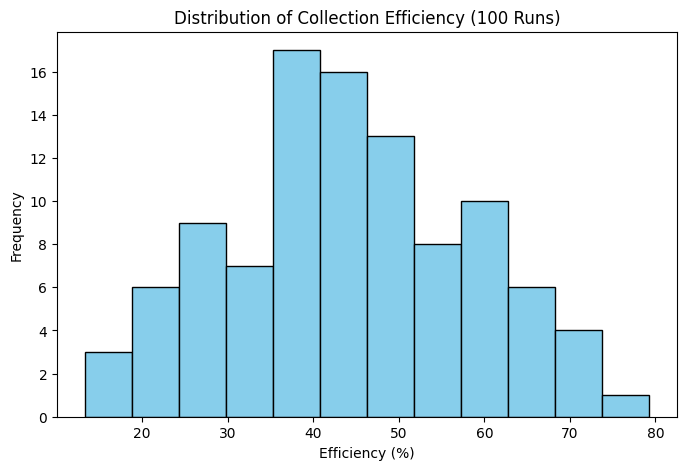

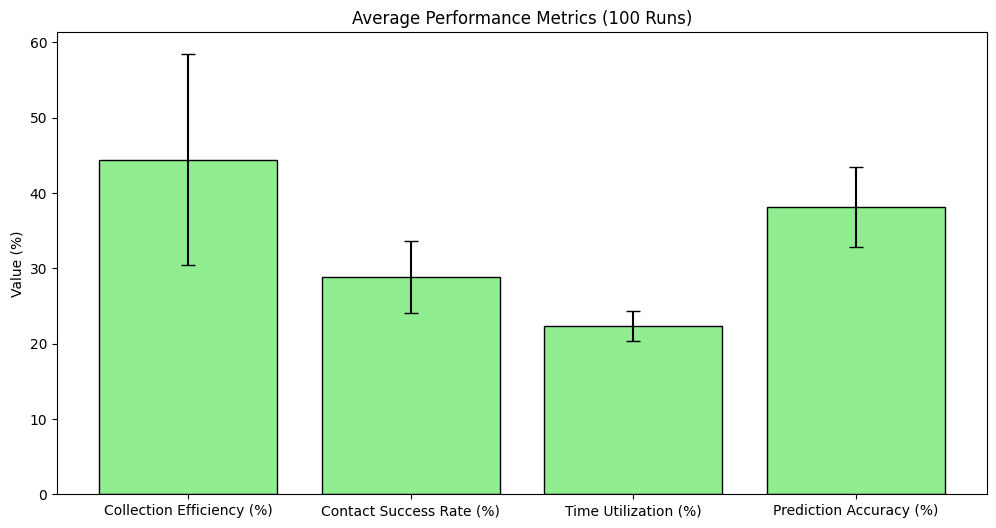

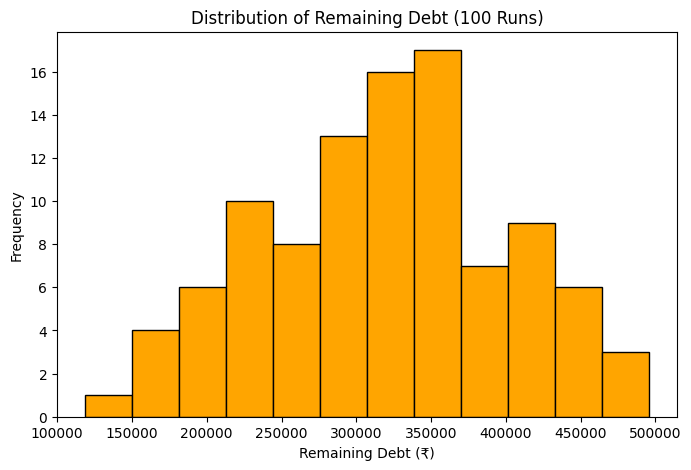

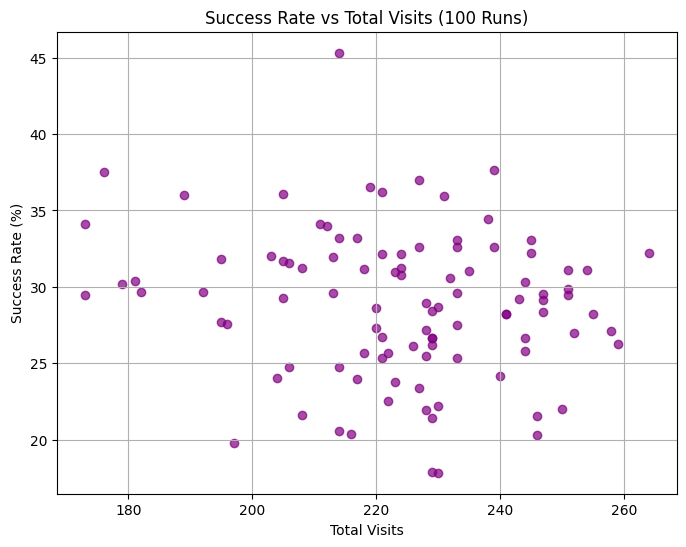

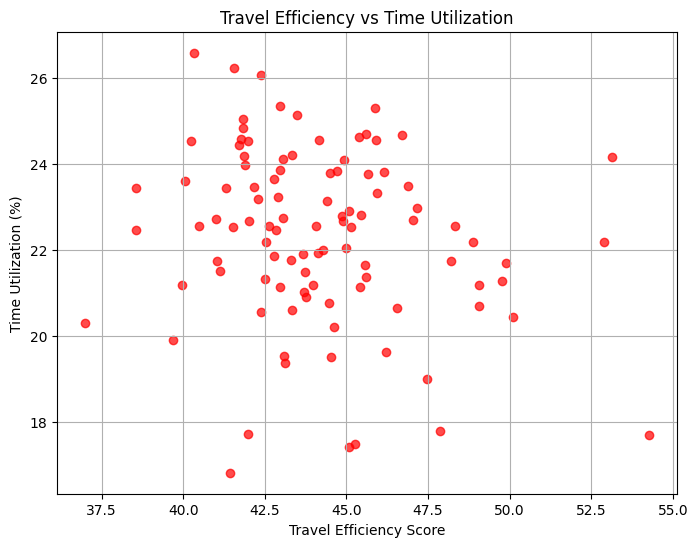

In [337]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# Run 100 simulations
# ============================
runs = [run_enhanced_premodeled_simulation(debtors_df) for _ in range(100)]
df = pd.DataFrame(runs)

# ============================
# Aggregated Stats
# ============================
numeric_df = df.drop(columns=["Optimal Times Discovered", "Behavior Types Detected"])
agg_df = numeric_df.agg(['mean', 'std', 'min', 'max']).T

print("\nAggregated Results (first 10 rows):")
print(agg_df.head(10))

# ============================
# 📊 Plot 1: Distribution of Collection Efficiency
# ============================
plt.figure(figsize=(8,5))
plt.hist(df["Collection Efficiency (%)"], bins=12, color="skyblue", edgecolor="black")
plt.title("Distribution of Collection Efficiency (100 Runs)")
plt.xlabel("Efficiency (%)")
plt.ylabel("Frequency")
plt.show()

# ============================
# 📊 Plot 2: Average with Error Bars
# ============================
plt.figure(figsize=(12,6))
metrics_to_plot = ["Collection Efficiency (%)", "Contact Success Rate (%)", "Time Utilization (%)", "Prediction Accuracy (%)"]
means = agg_df.loc[metrics_to_plot, "mean"]
stds = agg_df.loc[metrics_to_plot, "std"]

plt.bar(means.index, means.values, yerr=stds.values, capsize=5, color="lightgreen", edgecolor="black")
plt.title("Average Performance Metrics (100 Runs)")
plt.ylabel("Value (%)")
plt.show()

# ============================
# 📊 Plot 3: Remaining Debt Distribution
# ============================
plt.figure(figsize=(8,5))
plt.hist(df["Remaining Debt"], bins=12, color="orange", edgecolor="black")
plt.title("Distribution of Remaining Debt (100 Runs)")
plt.xlabel("Remaining Debt (₹)")
plt.ylabel("Frequency")
plt.show()

# ============================
# 📊 Plot 4: Scatter Success Rate vs Visits
# ============================
plt.figure(figsize=(8,6))
plt.scatter(df["Total Visits"], df["Contact Success Rate (%)"], alpha=0.7, c="purple")
plt.title("Success Rate vs Total Visits (100 Runs)")
plt.xlabel("Total Visits")
plt.ylabel("Success Rate (%)")
plt.grid(True)
plt.show()

# ============================
# 📊 Plot 5: Travel Efficiency vs Time Utilization
# ============================
plt.figure(figsize=(8,6))
plt.scatter(df["Travel Efficiency Score"], df["Time Utilization (%)"], alpha=0.7, c="red")
plt.title("Travel Efficiency vs Time Utilization")
plt.xlabel("Travel Efficiency Score")
plt.ylabel("Time Utilization (%)")
plt.grid(True)
plt.show()

In [338]:
df.to_csv('idkwhat.csv')

### Implementation of Multi armed bandit and seeing which optimisation technique gives best results - will check explore only , exploit only , epsilon greedy , dynamic reward the simulation will be run 1000 times finding the regret rho and comparing with absolute rho then comparing the aggregate of each strategy for 1000 runs will maybe output the best one. Also maybe then test some RL

In [339]:
debtors_df

,debtor_id,cluster,latitude,longitude,money_owed
0,D0_0,0,28.630809,77.234069,55001.15
1,D0_1,0,28.618110,77.211035,56402.35
2,D0_2,0,28.648078,77.214614,53595.56
3,D0_3,0,28.630561,77.215872,50865.20
4,D0_4,0,28.636263,77.218747,40100.37
5,D0_5,0,28.652945,77.237195,76270.04
6,D0_6,0,28.625410,77.223096,50806.63
7,D0_7,0,28.614526,77.217138,66457.94
8,D0_8,0,28.622215,77.207483,67493.67
9,D0_9,0,28.638408,77.232726,54866.41


In [340]:
route_df

,debtor_id,cluster,latitude,longitude,money_owed,visit_order,leg_dist_km,leg_time_hr
0,D0_7,0,28.634154,77.217734,22847.61,1,0.0719,0.002877
1,D0_4,0,28.636906,77.215052,47779.70,2,0.5228,0.020912
2,D0_5,0,28.630096,77.223242,49188.44,3,1.4304,0.057218
3,D0_1,0,28.626057,77.221506,54985.55,4,0.6224,0.024894
4,D0_0,0,28.622017,77.224007,41054.85,5,0.6633,0.026533
5,D0_9,0,28.621775,77.221434,48198.61,6,0.3290,0.013160
6,D0_3,0,28.622006,77.221288,43465.81,7,0.0380,0.001522
7,D0_2,0,28.612359,77.219105,56171.06,8,1.4174,0.056695
8,D0_6,0,28.624795,77.211642,51147.47,9,2.0275,0.081100
9,D0_8,0,28.626714,77.211010,43725.53,10,0.2879,0.011515


In [341]:
dist_mat

array([[0.        , 3.13970354, 1.28093257, 1.51173681, 0.96180517,
        1.85425291, 0.48785322, 1.31959152, 1.81706733, 1.94358063,
        0.07192769],
       [3.13970354, 0.        , 1.99709004, 2.02749184, 2.60911544,
        1.38860218, 3.57400779, 2.31012482, 1.41738624, 1.52463689,
        3.14507058],
       [1.28093257, 1.99709004, 0.        , 1.26706781, 0.62235501,
        0.61700934, 1.76527722, 1.33764961, 0.5843356 , 0.66331776,
        1.26134452],
       [1.51173681, 2.02749184, 1.26706781, 0.        , 1.66058544,
        1.31859721, 1.79791546, 0.28787153, 1.2904419 , 1.62207525,
        1.55493535],
       [0.96180517, 2.60911544, 0.62235501, 1.66058544, 0.        ,
        1.22072351, 1.43043994, 1.6294428 , 1.19178187, 1.16818345,
        0.91216605],
       [1.85425291, 1.38860218, 0.61700934, 1.31859721, 1.22072351,
        0.        , 2.3260243 , 1.50404366, 0.03804113, 0.32900507,
        1.84453028],
       [0.48785322, 3.57400779, 1.76527722, 1.79791546, 1.

In [342]:
COLLECTOR_SCHEDULES = {
    'C1': {'start': 7, 'end': 15},   # 7 AM to 3 PM
    'C2': {'start': 13, 'end': 22}   # 1 PM to 10 PM
}

VISIT_TIME_MINS_AVG = 20
VISIT_TIME_MINS_VAR = 8
TRAVEL_SPEED_KMH = 25
MAX_DAILY_TRAVEL_KM = 100
MIN_TIME_BETWEEN_VISITS = 5

COLLECTION_SUCCESS_RATE = 0.3
COLLECTION_AMOUNT_PCT_AVG = 0.6
COLLECTION_AMOUNT_PCT_VAR = 0.2

PERSON_AVAILABLE_PROB = 0.7
OUT_OF_STATION_PROB = 0.05
OUT_OF_STATION_DAYS_AVG = 5
OUT_OF_STATION_DAYS_VAR = 3

In [354]:
class DebtorState(Enum):
    FRESH = "fresh"  # Haven't been visited recently
    PRESSURED = "pressured"  # Been visited multiple times
    DEPLETED = "depleted"  # Gave money recently, low funds
    SALARY_INCOMING = "salary_incoming"  # Near salary date

@dataclass
class DebtorFinancialProfile:
    """Models a debtor's financial behavior and state"""
    monthly_income: float
    base_expenses_pct: float  # Percentage of income for basic expenses
    discretionary_pct: float  # Percentage available for debt payments
    payment_willingness: float  # Base willingness to pay (0-1)
    stress_factor: float  # How much pressure affects payment probability
    salary_date: int  # Day of month when salary arrives
    
class DebtorDynamicState:
    """Tracks the dynamic state of a debtor"""
    def __init__(self, debtor_id: str, profile: DebtorFinancialProfile, debt_amount: float):
        self.debtor_id = debtor_id
        self.profile = profile
        self.debt_amount = debt_amount
        self.current_balance = 0.0
        self.last_salary_date = None
        self.visit_history = []  # List of (date, collector_id, amount_collected)
        self.days_since_payment = 0
        self.pressure_level = 0.0  # Accumulated pressure from visits
        self.state = DebtorState.FRESH
        
    def update_daily_balance(self, current_date: datetime):
        """Update debtor's balance based on daily spending patterns"""
        # Check if salary day
        if current_date.day == self.profile.salary_date:
            self.current_balance = self.profile.monthly_income
            self.last_salary_date = current_date
            self.pressure_level = 0.0  # Reset pressure after salary
            self.days_since_payment += 1
            return
            
        # Daily expenses (higher on weekends)
        base_daily_expense = (self.profile.monthly_income * self.profile.base_expenses_pct) / 30
        weekend_multiplier = 1.5 if current_date.weekday() >= 5 else 1.0
        daily_expense = base_daily_expense * weekend_multiplier * np.random.normal(1.0, 0.2)
        
        self.current_balance = max(0, self.current_balance - daily_expense)
        self.days_since_payment += 1
        
        # Update state based on financial situation
        self._update_state(current_date)
    
    def _update_state(self, current_date: datetime):
        """Update debtor's psychological state"""
        days_to_salary = (self.profile.salary_date - current_date.day) % 30
        
        if days_to_salary <= 3:
            self.state = DebtorState.SALARY_INCOMING
        elif self.current_balance < (self.profile.monthly_income * 0.1):
            self.state = DebtorState.DEPLETED
        elif self.pressure_level > 0.5:
            self.state = DebtorState.PRESSURED
        else:
            self.state = DebtorState.FRESH
    
    def calculate_payment_probability(self, collector_id: str, current_date: datetime) -> float:
        """Calculate probability of payment based on current state"""
        base_prob = self.profile.payment_willingness
        
        # State-based modifiers
        state_modifiers = {
            DebtorState.FRESH: 1.0,
            DebtorState.PRESSURED: 1.3,  # Higher probability when pressured
            DebtorState.DEPLETED: 0.3,   # Lower when no money
            DebtorState.SALARY_INCOMING: 1.5  # Higher when salary is coming
        }
        
        # Balance factor
        balance_factor = min(1.0, self.current_balance / (self.debt_amount * 0.1))
        
        # Pressure factor (visits in last 7 days)
        recent_visits = [v for v in self.visit_history 
                        if (current_date - v[0]).days <= 7]
        pressure_boost = min(0.4, len(recent_visits) * 0.1)
        
        # Days since salary factor
        days_since_salary = (current_date - self.last_salary_date).days if self.last_salary_date else 15
        salary_factor = max(0.5, 1.0 - (days_since_salary / 30))
        
        probability = (base_prob * state_modifiers[self.state] * 
                      balance_factor * salary_factor + pressure_boost)
        
        return min(0.95, max(0.05, probability))
    
    def calculate_payment_amount(self) -> float:
        """Calculate how much debtor might pay if they decide to pay"""
        available_for_debt = self.current_balance * self.profile.discretionary_pct
        
        # Payment amount varies by state
        if self.state == DebtorState.SALARY_INCOMING:
            # Might pay more when salary is coming
            payment_pct = np.random.normal(0.7, 0.2)
        elif self.state == DebtorState.PRESSURED:
            # Moderate payment to relieve pressure
            payment_pct = np.random.normal(0.5, 0.15)
        elif self.state == DebtorState.DEPLETED:
            # Small payment if any
            payment_pct = np.random.normal(0.2, 0.1)
        else:
            # Normal payment
            payment_pct = np.random.normal(0.4, 0.15)
        
        payment_pct = max(0.1, min(0.8, payment_pct))
        potential_payment = min(available_for_debt * payment_pct, self.debt_amount)
        
        return max(0, potential_payment)
    
    def record_visit(self, collector_id: str, current_date: datetime, amount_collected: float):
        """Record a visit and its outcome"""
        self.visit_history.append((current_date, collector_id, amount_collected))
        self.debt_amount -= amount_collected
        self.current_balance -= amount_collected
        self.days_since_payment = 0 if amount_collected > 0 else self.days_since_payment
        
        # Increase pressure from visit
        self.pressure_level = min(1.0, self.pressure_level + 0.2)
        # Pressure decays over time
        self.pressure_level *= 0.95

class UCBDebtCollector:
    """Upper Confidence Bound algorithm for debt collection"""
    def __init__(self, debtor_ids: List[str], confidence_param: float = 2.0):
        self.debtor_ids = debtor_ids
        self.confidence_param = confidence_param
        self.visit_counts = {debtor_id: 0 for debtor_id in debtor_ids}
        self.total_rewards = {debtor_id: 0.0 for debtor_id in debtor_ids}
        self.total_visits = 0
        
    def calculate_ucb_score(self, debtor_id: str) -> float:
        """Calculate UCB score for a debtor"""
        if self.visit_counts[debtor_id] == 0:
            return float('inf')  # Prioritize unvisited debtors
        
        avg_reward = self.total_rewards[debtor_id] / self.visit_counts[debtor_id]
        confidence_interval = np.sqrt(
            (self.confidence_param * np.log(self.total_visits)) / 
            self.visit_counts[debtor_id]
        )
        
        return avg_reward + confidence_interval
    
    def select_debtor(self, available_debtors: List[str]) -> str:
        """Select next debtor to visit based on UCB"""
        if not available_debtors:
            return None
            
        ucb_scores = {debtor_id: self.calculate_ucb_score(debtor_id) 
                     for debtor_id in available_debtors}
        
        return max(ucb_scores.keys(), key=lambda x: ucb_scores[x])
    
    def update_reward(self, debtor_id: str, reward: float):
        """Update algorithm with visit outcome"""
        self.visit_counts[debtor_id] += 1
        self.total_rewards[debtor_id] += reward
        self.total_visits += 1

class ThompsonSamplingCollector:
    """Thompson Sampling algorithm for debt collection"""
    def __init__(self, debtor_ids: List[str]):
        self.debtor_ids = debtor_ids
        # Beta distribution parameters for each debtor
        self.alpha = {debtor_id: 1.0 for debtor_id in debtor_ids}  # Successes + 1
        self.beta = {debtor_id: 1.0 for debtor_id in debtor_ids}   # Failures + 1
        
    def select_debtor(self, available_debtors: List[str]) -> str:
        """Select debtor using Thompson Sampling"""
        if not available_debtors:
            return None
            
        # Sample from beta distributions
        sampled_probs = {}
        for debtor_id in available_debtors:
            sampled_probs[debtor_id] = np.random.beta(
                self.alpha[debtor_id], self.beta[debtor_id]
            )
        
        return max(sampled_probs.keys(), key=lambda x: sampled_probs[x])
    
    def update_reward(self, debtor_id: str, reward: float):
        """Update Beta distribution parameters"""
        if reward > 0:
            self.alpha[debtor_id] += reward  # Weighted by amount collected
        else:
            self.beta[debtor_id] += 1

class DebtCollectionSimulator:
    """Main simulation engine for debt collection optimization"""
    
    def __init__(self, debtors_df: pd.DataFrame, dist_matrix: np.ndarray, 
                 income_config: Dict = None):
        self.debtors_df = debtors_df.copy()
        self.dist_matrix = dist_matrix
        self.debtor_states = {}
        self.collectors = {}
        self.simulation_results = []
        
        # Income configuration with defaults
        self.income_config = income_config or {
            'base_income': 25000,      # Base monthly income in INR
            'income_variance': 8000,   # Standard deviation of income
            'min_income': 10000,       # Minimum income floor
            'max_income': 100000,      # Maximum income ceiling
            'income_distribution': 'normal'  # 'normal', 'lognormal', or 'uniform'
        }
        
        # Add salary dates (1st of each month with some variation)
        self.debtors_df['salary_date'] = np.random.choice([1, 2, 3], size=len(debtors_df))
        
        # Generate and add income column
        self._generate_debtor_incomes()
        
        # Initialize debtor states - THIS WAS MISSING!
        self._initialize_debtors()
        
    def _generate_debtor_incomes(self):
        """Generate debtor incomes based on configuration"""
        n_debtors = len(self.debtors_df)
        
        if self.income_config['income_distribution'] == 'normal':
            incomes = np.random.normal(
                self.income_config['base_income'], 
                self.income_config['income_variance'], 
                n_debtors
            )
        elif self.income_config['income_distribution'] == 'lognormal':
            # Log-normal distribution (more realistic for income)
            mu = np.log(self.income_config['base_income'])
            sigma = self.income_config['income_variance'] / self.income_config['base_income']
            incomes = np.random.lognormal(mu, sigma, n_debtors)
        elif self.income_config['income_distribution'] == 'uniform':
            low = self.income_config['base_income'] - self.income_config['income_variance']
            high = self.income_config['base_income'] + self.income_config['income_variance']
            incomes = np.random.uniform(low, high, n_debtors)
        else:
            # Default to normal
            incomes = np.random.normal(
                self.income_config['base_income'], 
                self.income_config['income_variance'], 
                n_debtors
            )
        
        # Apply income bounds
        incomes = np.clip(incomes, 
                         self.income_config['min_income'], 
                         self.income_config['max_income'])
        
        self.debtors_df['monthly_income'] = incomes
        
        # Calculate debt-to-income ratio for analysis
        self.debtors_df['debt_to_income_ratio'] = (
            self.debtors_df['money_owed'] / self.debtors_df['monthly_income']
        )
        
        # Ensure debtor_id is string type for consistency
        self.debtors_df['debtor_id'] = self.debtors_df['debtor_id'].astype(str)
        
    def _initialize_debtors(self):
        """Initialize debtor financial profiles and states"""
        for idx, row in self.debtors_df.iterrows():
            debtor_id = str(row['debtor_id'])  # Ensure string type
            monthly_income = row['monthly_income']  # Use generated income
            debt_amount = row['money_owed']
            
            # Create financial profile based on income level and debt ratio
            debt_to_income = debt_amount / monthly_income
            
            # Adjust financial behavior based on income level and debt burden
            if monthly_income < 15000:  # Low income
                base_expenses_pct = np.random.normal(0.85, 0.05)  # Higher expenses %
                discretionary_pct = np.random.normal(0.08, 0.03)  # Less discretionary
                payment_willingness = np.random.beta(1.5, 4)      # Lower willingness
            elif monthly_income > 50000:  # High income
                base_expenses_pct = np.random.normal(0.60, 0.10)  # Lower expenses %
                discretionary_pct = np.random.normal(0.25, 0.08)  # More discretionary
                payment_willingness = np.random.beta(3, 2)        # Higher willingness
            else:  # Medium income
                base_expenses_pct = np.random.normal(0.70, 0.08)
                discretionary_pct = np.random.normal(0.15, 0.05)
                payment_willingness = np.random.beta(2, 3)
            
            # Adjust willingness based on debt burden
            if debt_to_income > 0.5:  # High debt burden
                payment_willingness *= 0.7  # Reduce willingness
                stress_factor = np.random.normal(1.5, 0.2)  # Higher stress
            elif debt_to_income < 0.1:  # Low debt burden
                payment_willingness *= 1.3  # Increase willingness
                stress_factor = np.random.normal(0.8, 0.2)  # Lower stress
            else:
                stress_factor = np.random.normal(1.0, 0.2)
            
            profile = DebtorFinancialProfile(
                monthly_income=monthly_income,
                base_expenses_pct=max(0.4, min(0.9, base_expenses_pct)),
                discretionary_pct=max(0.05, min(0.3, discretionary_pct)),
                payment_willingness=max(0.05, min(0.95, payment_willingness)),
                stress_factor=max(0.5, min(2.0, stress_factor)),
                salary_date=row['salary_date']
            )
            
            self.debtor_states[debtor_id] = DebtorDynamicState(
                debtor_id, profile, debt_amount
            )
    
    def _calculate_travel_time(self, from_idx: int, to_idx: int) -> float:
        """Calculate travel time between two locations"""
        distance_km = self.dist_matrix[from_idx][to_idx]
        return (distance_km / TRAVEL_SPEED_KMH) * 60  # Convert to minutes
    
    def _can_visit_debtor(self, collector_id: str, debtor_idx: int, 
                         current_location: int, current_time: int, 
                         daily_travel: float) -> bool:
        """Check if collector can visit a debtor given constraints"""
        schedule = COLLECTOR_SCHEDULES[collector_id]
        
        # Check time constraints
        travel_time = self._calculate_travel_time(current_location, debtor_idx)
        arrival_time = current_time + travel_time
        departure_time = arrival_time + np.random.normal(VISIT_TIME_MINS_AVG, VISIT_TIME_MINS_VAR)
        
        if arrival_time < schedule['start'] * 60 or departure_time > schedule['end'] * 60:
            return False
        
        # Check travel distance constraint
        additional_travel = self.dist_matrix[current_location][debtor_idx]
        if daily_travel + additional_travel > MAX_DAILY_TRAVEL_KM:
            return False
            
        return True
    
    def _simulate_visit(self, debtor_id: str, collector_id: str, 
                       current_date: datetime) -> Tuple[float, bool]:
        """Simulate a visit to a debtor"""
        debtor_state = self.debtor_states[debtor_id]
        
        # Check if person is available
        if np.random.random() > PERSON_AVAILABLE_PROB:
            return 0.0, False  # Person not available
        
        # Check if out of station
        if np.random.random() < OUT_OF_STATION_PROB:
            return 0.0, False  # Out of station
        
        # Calculate payment probability
        payment_prob = debtor_state.calculate_payment_probability(collector_id, current_date)
        
        if np.random.random() < payment_prob:
            # Person decides to pay
            payment_amount = debtor_state.calculate_payment_amount()
            debtor_state.record_visit(collector_id, current_date, payment_amount)
            return payment_amount, True
        else:
            # Person doesn't pay but visit creates pressure
            debtor_state.record_visit(collector_id, current_date, 0.0)
            return 0.0, True  # Visit successful but no payment

class AdaptiveDebtCollectionMAB:
    """Multi-Armed Bandit for adaptive debt collection"""
    
    def __init__(self, debtors_df: pd.DataFrame, dist_matrix: np.ndarray, 
                 algorithm: str = "ucb", income_config: Dict = None):
        self.simulator = DebtCollectionSimulator(debtors_df, dist_matrix, income_config)
        self.algorithm = algorithm
        self.collectors = {}
        
        # Initialize MAB algorithms for each collector
        debtor_ids = [str(id) for id in debtors_df['debtor_id'].tolist()]  # Ensure string type
        for collector_id in COLLECTOR_SCHEDULES.keys():
            if algorithm == "ucb":
                self.collectors[collector_id] = UCBDebtCollector(debtor_ids)
            elif algorithm == "thompson":
                self.collectors[collector_id] = ThompsonSamplingCollector(debtor_ids)
    
    def _calculate_dynamic_reward(self, debtor_id: str, amount_collected: float, 
                                 visit_successful: bool, current_date: datetime) -> float:
        """Calculate dynamic reward based on multiple factors"""
        debtor_state = self.simulator.debtor_states[debtor_id]
        
        # Base reward from amount collected
        if amount_collected > 0:
            # Normalize by debt amount to make comparable across debtors
            base_reward = amount_collected / max(100, debtor_state.debt_amount)  # Prevent division by very small numbers
        else:
            base_reward = 0.0
        
        # Penalize unsuccessful visits
        if not visit_successful:
            return -0.1  # Negative reward for wasted trip
        
        # Time-based multipliers
        days_to_salary = (debtor_state.profile.salary_date - current_date.day) % 30
        
        # Higher reward for collections close to salary date
        if days_to_salary <= 5:
            base_reward *= 1.5
        elif days_to_salary <= 10:
            base_reward *= 1.2
        
        # Bonus for breakthrough payments (first payment from pressured debtor)
        if (amount_collected > 0 and debtor_state.state == DebtorState.PRESSURED and 
            len([v for v in debtor_state.visit_history if v[2] > 0]) == 1):
            base_reward *= 2.0
        
        # Penalty for visiting depleted debtors
        if debtor_state.state == DebtorState.DEPLETED:
            base_reward *= 0.5
        
        return base_reward
    
    def _get_available_debtors(self, collector_id: str, current_location: int,
                              current_time: int, daily_travel: float) -> List[str]:
        """Get list of debtors that can be visited given current constraints"""
        available = []
        
        for i, (_, row) in enumerate(self.simulator.debtors_df.iterrows()):
            debtor_id = str(row['debtor_id'])  # Ensure string consistency
            debtor_state = self.simulator.debtor_states[debtor_id]
            
            # Skip if debt already collected
            if debtor_state.debt_amount <= 0:
                continue
                
            # Check if visit is feasible
            if self.simulator._can_visit_debtor(collector_id, i, current_location, 
                                              current_time, daily_travel):
                available.append(debtor_id)
        
        return available
    
    def simulate_day(self, current_date: datetime, collector_id: str) -> Dict:
        """Simulate one day of debt collection for a collector"""
        schedule = COLLECTOR_SCHEDULES[collector_id]
        current_time = schedule['start'] * 60  # Convert to minutes
        end_time = schedule['end'] * 60
        current_location = 0  # Start from office/depot
        daily_travel = 0.0
        daily_collections = 0.0
        visits_made = []
        
        mab_algorithm = self.collectors[collector_id]
        
        # Update all debtor states for the new day
        for debtor_state in self.simulator.debtor_states.values():
            debtor_state.update_daily_balance(current_date)
        
        while current_time < end_time:
            # Get available debtors for visit
            available_debtors = self._get_available_debtors(
                collector_id, current_location, current_time, daily_travel
            )
            
            if not available_debtors:
                break
            
            # Select debtor using MAB algorithm
            selected_debtor = mab_algorithm.select_debtor(available_debtors)
            if not selected_debtor:
                break
            
            # Get debtor index for distance calculation
            debtor_idx = self.simulator.debtors_df[
                self.simulator.debtors_df['debtor_id'] == selected_debtor
            ].index[0]
            
            # Calculate travel and visit
            travel_time = self.simulator._calculate_travel_time(current_location, debtor_idx)
            visit_time = max(10, np.random.normal(VISIT_TIME_MINS_AVG, VISIT_TIME_MINS_VAR))
            
            # Simulate the visit
            amount_collected, visit_successful = self.simulator._simulate_visit(
                selected_debtor, collector_id, current_date
            )
            
            # Calculate reward and update MAB
            reward = self._calculate_dynamic_reward(
                selected_debtor, amount_collected, visit_successful, current_date
            )
            mab_algorithm.update_reward(selected_debtor, reward)
            
            # Update tracking variables
            current_time += travel_time + visit_time
            current_location = debtor_idx
            daily_travel += self.simulator.dist_matrix[current_location][debtor_idx] if current_location != debtor_idx else 0
            daily_collections += amount_collected
            
            # Record visit details
            visits_made.append({
                'debtor_id': selected_debtor,
                'amount_collected': amount_collected,
                'visit_successful': visit_successful,
                'debtor_state': self.simulator.debtor_states[selected_debtor].state.value,
                'travel_time': travel_time,
                'visit_time': visit_time,
                'reward': reward
            })
            
        return {
            'date': current_date,
            'collector_id': collector_id,
            'total_collected': daily_collections,
            'visits_made': len(visits_made),
            'successful_visits': sum(1 for v in visits_made if v['visit_successful']),
            'total_travel_km': daily_travel,
            'visits_detail': visits_made
        }
    
    def run_simulation(self, start_date: datetime, num_days: int) -> pd.DataFrame:
        """Run complete simulation for specified period"""
        results = []
        
        for day in range(num_days):
            current_date = start_date + timedelta(days=day)
            
            for collector_id in COLLECTOR_SCHEDULES.keys():
                day_result = self.simulate_day(current_date, collector_id)
                results.append(day_result)
        
        return pd.DataFrame(results)
    
    def get_performance_metrics(self, results_df: pd.DataFrame) -> Dict:
        """Calculate performance metrics"""
        total_collected = results_df['total_collected'].sum()
        total_visits = results_df['visits_made'].sum()
        avg_collection_per_visit = total_collected / max(1, total_visits)
        
        # Calculate collection rate by debtor state
        state_performance = {}
        for _, day_result in results_df.iterrows():
            if day_result['visits_detail']:  # Check if visits_detail is not empty
                for visit in day_result['visits_detail']:
                    state = visit['debtor_state']
                    if state not in state_performance:
                        state_performance[state] = {'collections': 0, 'visits': 0}
                    
                    state_performance[state]['visits'] += 1
                    if visit['amount_collected'] > 0:
                        state_performance[state]['collections'] += visit['amount_collected']
        
        return {
            'total_collected': total_collected,
            'total_visits': total_visits,
            'avg_collection_per_visit': avg_collection_per_visit,
            'collection_efficiency': total_collected / max(1, results_df['total_travel_km'].sum()),
            'state_performance': state_performance
        }


In [357]:
def run_debt_collection_optimization(debtors_df, dist_matrix, income_config: Dict = None):
    """Run the complete debt collection optimization with controllable income"""
    
    # Use provided income config or default
    if income_config is None:
        income_config = {
            'base_income': 25000,
            'income_variance': 8000,
            'min_income': 10000,
            'max_income': 100000,
            'income_distribution': 'normal'
        }
    
    # Initialize simulation with income configuration
    mab_system = AdaptiveDebtCollectionMAB(
        debtors_df, dist_matrix, 
        algorithm="ucb", 
        income_config=income_config
    )
    
    # Run simulation for 30 days
    start_date = datetime(2024, 1, 15)
    results = mab_system.run_simulation(start_date, 30)
    
    # Get performance metrics
    metrics = mab_system.get_performance_metrics(results)
    
    print("Debt Collection Optimization Results:")
    print(f"Income Configuration: {income_config}")
    print(f"Total Amount Collected: ₹{metrics['total_collected']:.2f}")
    print(f"Total Visits Made: {metrics['total_visits']}")
    print(f"Average Collection per Visit: ₹{metrics['avg_collection_per_visit']:.2f}")
    print(f"Collection Efficiency (₹/km): ₹{metrics['collection_efficiency']:.2f}")
    
    # Show debtor income analysis
    print(f"\nDebtor Income Analysis:")
    income_df = mab_system.simulator.debtors_df[['debtor_id', 'monthly_income', 'money_owed', 'debt_to_income_ratio']]
    print(income_df.to_string())
    
    print("\nPerformance by Debtor State:")
    for state, perf in metrics['state_performance'].items():
        avg_collection = perf['collections'] / max(1, perf['visits']) if perf['visits'] > 0 else 0
        print(f"{state}: ₹{avg_collection:.2f} per visit ({perf['visits']} visits)")
    
    return results, metrics, mab_system

In [358]:
run_debt_collection_optimization(debtors_df, dist_mat)

Debt Collection Optimization Results:
Income Configuration: {'base_income': 25000, 'income_variance': 8000, 'min_income': 10000, 'max_income': 100000, 'income_distribution': 'normal'}
Total Amount Collected: ₹247492.25
Total Visits Made: 1293
Average Collection per Visit: ₹191.41
Collection Efficiency (₹/km): ₹247492.25

Debtor Income Analysis:
  debtor_id  monthly_income  money_owed  debt_to_income_ratio
0      D0_0    35907.114199    55001.15              1.531762
1      D0_1    28561.050184    56402.35              1.974800
2      D0_2    24142.427510    53595.56              2.219974
3      D0_3    31005.778658    50865.20              1.640507
4      D0_4    20569.618823    40100.37              1.949495
5      D0_5    34466.087444    76270.04              2.212901
6      D0_6    53657.300763    50806.63              0.946873
7      D0_7    24627.161863    66457.94              2.698563
8      D0_8    37237.115543    67493.67              1.812538
9      D0_9    25163.330897    54

(         date collector_id  total_collected  visits_made  successful_visits  \
 0  2024-01-15           C1         0.000000           21                 16   
 1  2024-01-15           C2         0.000000           23                 15   
 2  2024-01-16           C1         0.000000           20                 16   
 3  2024-01-16           C2         0.000000           22                 15   
 4  2024-01-17           C1         0.000000           18                 12   
 5  2024-01-17           C2         0.000000           23                 17   
 6  2024-01-18           C1         0.000000           21                 12   
 7  2024-01-18           C2         0.000000           21                 15   
 8  2024-01-19           C1         0.000000           22                 18   
 9  2024-01-19           C2         0.000000           21                 15   
 10 2024-01-20           C1         0.000000           21                 14   
 11 2024-01-20           C2         0.00

In [361]:
def run_single_simulation(debtors_df, dist_matrix, algorithm, income_config):
    """Run a single simulation without printing"""
    mab_system = AdaptiveDebtCollectionMAB(
        debtors_df, dist_matrix, 
        algorithm=algorithm, 
        income_config=income_config
    )
    
    start_date = datetime(2024, 1, 1)
    results = mab_system.run_simulation(start_date, 30)
    metrics = mab_system.get_performance_metrics(results)
    
    return metrics

In [362]:
def run_comprehensive_comparison(debtors_df, dist_matrix, num_runs=1000):
    """Run comprehensive comparison of UCB vs Thompson Sampling"""
    
    # Generate random income configurations
    income_configs = []
    distributions = ['normal', 'lognormal']
    
    for _ in range(num_runs):
        distribution = np.random.choice(distributions)
        
        if distribution == 'normal':
            base_income = np.random.uniform(15000, 80000)
            income_variance = np.random.uniform(3000, 20000)
            min_income = max(8000, base_income - 2 * income_variance)
            max_income = base_income + 2 * income_variance
        else:  # lognormal
            base_income = np.random.uniform(20000, 60000)
            income_variance = np.random.uniform(5000, 15000)
            min_income = max(10000, base_income * 0.3)
            max_income = base_income * 3
        
        income_configs.append({
            'base_income': base_income,
            'income_variance': income_variance,
            'min_income': min_income,
            'max_income': max_income,
            'income_distribution': distribution
        })
    
    # Storage for results
    ucb_results = []
    thompson_results = []
    
    # Run simulations
    for i, income_config in enumerate(income_configs):
        if i % 100 == 0:
            print(f"Completed {i}/{num_runs} runs...")
        
        # UCB simulation
        try:
            ucb_metrics = run_single_simulation(debtors_df, dist_matrix, "ucb", income_config)
            ucb_results.append({
                'run_id': i,
                'distribution': income_config['income_distribution'],
                'base_income': income_config['base_income'],
                'income_variance': income_config['income_variance'],
                'total_collected': ucb_metrics['total_collected'],
                'total_visits': ucb_metrics['total_visits'],
                'avg_collection_per_visit': ucb_metrics['avg_collection_per_visit'],
                'collection_efficiency': ucb_metrics['collection_efficiency']
            })
        except Exception as e:
            print(f"UCB run {i} failed: {e}")
            continue
        
        # Thompson Sampling simulation
        try:
            thompson_metrics = run_single_simulation(debtors_df, dist_matrix, "thompson", income_config)
            thompson_results.append({
                'run_id': i,
                'distribution': income_config['income_distribution'],
                'base_income': income_config['base_income'],
                'income_variance': income_config['income_variance'],
                'total_collected': thompson_metrics['total_collected'],
                'total_visits': thompson_metrics['total_visits'],
                'avg_collection_per_visit': thompson_metrics['avg_collection_per_visit'],
                'collection_efficiency': thompson_metrics['collection_efficiency']
            })
        except Exception as e:
            print(f"Thompson run {i} failed: {e}")
            continue
    
    # Convert to DataFrames for analysis
    ucb_df = pd.DataFrame(ucb_results)
    thompson_df = pd.DataFrame(thompson_results)
    
    # Calculate aggregate statistics
    print("\n" + "="*50)
    print("COMPREHENSIVE UCB vs THOMPSON SAMPLING COMPARISON")
    print("="*50)
    print(f"Total Successful Runs: UCB={len(ucb_df)}, Thompson={len(thompson_df)}")
    
    if len(ucb_df) > 0 and len(thompson_df) > 0:
        print("\nAGGREGATE PERFORMANCE METRICS:")
        print("-" * 30)
        
        metrics = ['total_collected', 'avg_collection_per_visit', 'collection_efficiency']
        for metric in metrics:
            ucb_mean = ucb_df[metric].mean()
            ucb_std = ucb_df[metric].std()
            thompson_mean = thompson_df[metric].mean()
            thompson_std = thompson_df[metric].std()
            
            print(f"\n{metric.upper().replace('_', ' ')}:")
            print(f"  UCB:       {ucb_mean:.2f} ± {ucb_std:.2f}")
            print(f"  Thompson:  {thompson_mean:.2f} ± {thompson_std:.2f}")
            
            # Statistical significance test (simple comparison)
            difference_pct = ((thompson_mean - ucb_mean) / ucb_mean * 100) if ucb_mean > 0 else 0
            winner = "Thompson" if thompson_mean > ucb_mean else "UCB"
            print(f"  Winner:    {winner} ({abs(difference_pct):.1f}% better)")
        
        print("\nPERFORMANCE BY INCOME DISTRIBUTION:")
        print("-" * 35)
        
        for dist in ['normal', 'lognormal']:
            ucb_dist = ucb_df[ucb_df['distribution'] == dist]
            thompson_dist = thompson_df[thompson_df['distribution'] == dist]
            
            if len(ucb_dist) > 0 and len(thompson_dist) > 0:
                print(f"\n{dist.upper()} DISTRIBUTION:")
                ucb_collected = ucb_dist['total_collected'].mean()
                thompson_collected = thompson_dist['total_collected'].mean()
                ucb_efficiency = ucb_dist['collection_efficiency'].mean()
                thompson_efficiency = thompson_dist['collection_efficiency'].mean()
                
                print(f"  Total Collected:     UCB={ucb_collected:.2f}, Thompson={thompson_collected:.2f}")
                print(f"  Collection Efficiency: UCB={ucb_efficiency:.2f}, Thompson={thompson_efficiency:.2f}")
                
                collected_winner = "Thompson" if thompson_collected > ucb_collected else "UCB"
                efficiency_winner = "Thompson" if thompson_efficiency > ucb_efficiency else "UCB"
                print(f"  Winners:             Collections={collected_winner}, Efficiency={efficiency_winner}")
        
        print("\nOVERALL WINNER:")
        print("-" * 15)
        
        # Determine overall winner based on multiple metrics
        ucb_wins = 0
        thompson_wins = 0
        
        for metric in metrics:
            if thompson_df[metric].mean() > ucb_df[metric].mean():
                thompson_wins += 1
            else:
                ucb_wins += 1
        
        overall_winner = "Thompson Sampling" if thompson_wins > ucb_wins else "UCB"
        print(f"Overall Winner: {overall_winner} ({max(ucb_wins, thompson_wins)}/{len(metrics)} metrics)")
        
        return {
            'ucb_results': ucb_df,
            'thompson_results': thompson_df,
            'summary': {
                'ucb_avg_collected': ucb_df['total_collected'].mean(),
                'thompson_avg_collected': thompson_df['total_collected'].mean(),
                'ucb_avg_efficiency': ucb_df['collection_efficiency'].mean(),
                'thompson_avg_efficiency': thompson_df['collection_efficiency'].mean(),
                'overall_winner': overall_winner
            }
        }
    else:
        print("Insufficient data for comparison")
        return None

In [363]:
comparison_results = run_comprehensive_comparison(debtors_df, dist_mat, num_runs=1000)

Completed 0/1000 runs...
Completed 100/1000 runs...
Completed 200/1000 runs...
Completed 300/1000 runs...
Completed 400/1000 runs...
Completed 500/1000 runs...
Completed 600/1000 runs...
Completed 700/1000 runs...
Completed 800/1000 runs...
Completed 900/1000 runs...

COMPREHENSIVE UCB vs THOMPSON SAMPLING COMPARISON
Total Successful Runs: UCB=1000, Thompson=1000

AGGREGATE PERFORMANCE METRICS:
------------------------------

TOTAL COLLECTED:
  UCB:       299860.43 ± 132606.17
  Thompson:  298165.24 ± 132785.29
  Winner:    UCB (0.6% better)

AVG COLLECTION PER VISIT:
  UCB:       238.55 ± 167.75
  Thompson:  230.90 ± 143.95
  Winner:    UCB (3.2% better)

COLLECTION EFFICIENCY:
  UCB:       299860.43 ± 132606.17
  Thompson:  298165.24 ± 132785.29
  Winner:    UCB (0.6% better)

PERFORMANCE BY INCOME DISTRIBUTION:
-----------------------------------

NORMAL DISTRIBUTION:
  Total Collected:     UCB=318947.98, Thompson=317394.09
  Collection Efficiency: UCB=318947.98, Thompson=317394.09


In [365]:
comparison_results

{'ucb_results':      run_id distribution   base_income  income_variance  total_collected  \
 0         0    lognormal  34695.861764     13691.966574    247659.142980   
 1         1    lognormal  57056.019173     11564.868325    476590.745160   
 2         2    lognormal  31635.120772     12482.754225    253247.509448   
 3         3       normal  37462.552393      9957.900644    221790.162286   
 4         4    lognormal  23283.628429      9195.168797    233262.224585   
 ..      ...          ...           ...              ...              ...   
 995     995    lognormal  57521.891332     10414.849020    500458.127290   
 996     996       normal  50788.770663     15765.680935    339927.458002   
 997     997       normal  59499.504767      6482.994772    517277.871013   
 998     998    lognormal  38797.975024      8381.262632    258818.490792   
 999     999    lognormal  48528.060064      9651.275623    364016.514102   
 
      total_visits  avg_collection_per_visit  collection_ef

In [366]:
from scipy.stats import ttest_ind, mannwhitneyu

def validate_null_hypothesis(comparison_results, metrics=['total_collected', 'avg_collection_per_visit', 'collection_efficiency']):
    """
    Perform statistical tests to validate null hypothesis:
    H0: No difference between UCB and Thompson Sampling for given metric
    H1: There is a difference
    """
    ucb_df = comparison_results['ucb_results']
    thompson_df = comparison_results['thompson_results']
    
    results = {}
    
    for metric in metrics:
        ucb_values = ucb_df[metric].dropna()
        thompson_values = thompson_df[metric].dropna()
        
        # Welch’s t-test (unequal variance allowed)
        t_stat, p_ttest = ttest_ind(ucb_values, thompson_values, equal_var=False)
        
        # Mann-Whitney U test (non-parametric)
        u_stat, p_mannwhitney = mannwhitneyu(ucb_values, thompson_values, alternative='two-sided')
        
        ucb_mean = ucb_values.mean()
        thompson_mean = thompson_values.mean()
        
        results[metric] = {
            'ucb_mean': ucb_mean,
            'thompson_mean': thompson_mean,
            't_stat': t_stat,
            'p_value_ttest': p_ttest,
            'u_stat': u_stat,
            'p_value_mannwhitney': p_mannwhitney,
            'winner': "Thompson" if thompson_mean > ucb_mean else "UCB",
            'significant_ttest': p_ttest < 0.05,
            'significant_mannwhitney': p_mannwhitney < 0.05
        }
    
    print("\n" + "="*50)
    print("NULL HYPOTHESIS TEST RESULTS")
    print("="*50)
    for metric, vals in results.items():
        print(f"\nMetric: {metric.upper().replace('_',' ')}")
        print(f"  UCB Mean={vals['ucb_mean']:.2f}, Thompson Mean={vals['thompson_mean']:.2f}")
        print(f"  T-test: t={vals['t_stat']:.3f}, p={vals['p_value_ttest']:.4f} -> Significant? {vals['significant_ttest']}")
        print(f"  Mann-Whitney U: U={vals['u_stat']:.3f}, p={vals['p_value_mannwhitney']:.4f} -> Significant? {vals['significant_mannwhitney']}")
        print(f"  Winner: {vals['winner']}")
    
    return results

In [367]:
hypothesis_results = validate_null_hypothesis(comparison_results)


NULL HYPOTHESIS TEST RESULTS

Metric: TOTAL COLLECTED
  UCB Mean=299860.43, Thompson Mean=298165.24
  T-test: t=0.286, p=0.7752 -> Significant? False
  Mann-Whitney U: U=504086.500, p=0.7517 -> Significant? False
  Winner: UCB

Metric: AVG COLLECTION PER VISIT
  UCB Mean=238.55, Thompson Mean=230.90
  T-test: t=1.094, p=0.2741 -> Significant? False
  Mann-Whitney U: U=515069.000, p=0.2432 -> Significant? False
  Winner: UCB

Metric: COLLECTION EFFICIENCY
  UCB Mean=299860.43, Thompson Mean=298165.24
  T-test: t=0.286, p=0.7752 -> Significant? False
  Mann-Whitney U: U=504086.500, p=0.7517 -> Significant? False
  Winner: UCB


In [387]:
def create_debt_recovery_timeline_from_existing_data(comparison_results):
    """
    Create debt recovery timeline visualization from your existing comparison_results
    This works with the data you already have without needing new simulations
    """
    
    print("Creating debt recovery timeline from existing comparison results...")
    
    # Extract the data
    ucb_df = pd.DataFrame(comparison_results['ucb_results'])
    thompson_df = pd.DataFrame(comparison_results['thompson_results'])
    
    # Add algorithm labels
    ucb_df['algorithm'] = 'UCB'
    thompson_df['algorithm'] = 'Thompson Sampling'
    
    # Combine datasets
    combined_df = pd.concat([ucb_df, thompson_df], ignore_index=True)
    
    print(f"Analyzing {len(ucb_df)} UCB runs and {len(thompson_df)} Thompson runs...")
    
    # Create synthetic daily progression based on total visits and collection
    synthetic_timeseries = []
    
    for _, row in combined_df.iterrows():
        total_visits = row['total_visits']
        total_collected = row['total_collected']
        algorithm = row['algorithm']
        
        # Estimate collection timeline over 30 days
        # Assume collections follow a realistic pattern: slow start, acceleration, then plateau
        
        days_to_simulate = 30
        for day in range(1, days_to_simulate + 1):
            # Create realistic collection curve using sigmoid-like function
            # This models: slow start, rapid middle phase, plateau at end
            day_progress = day / days_to_simulate
            
            # S-curve for realistic debt collection pattern
            if day_progress <= 0.1:  # First 10% of time - slow start
                collection_factor = 0.05 * day_progress / 0.1
            elif day_progress <= 0.8:  # Middle 70% - rapid collection
                collection_factor = 0.05 + 0.85 * (day_progress - 0.1) / 0.7
            else:  # Last 20% - plateau/diminishing returns
                collection_factor = 0.9 + 0.1 * (day_progress - 0.8) / 0.2
            
            # Calculate amounts for this day
            cumulative_collected = total_collected * collection_factor
            daily_collected = cumulative_collected - (
                total_collected * (
                    0.05 * (day-1)/days_to_simulate/0.1 if (day-1)/days_to_simulate <= 0.1 
                    else 0.05 + 0.85 * ((day-1)/days_to_simulate - 0.1) / 0.7 if (day-1)/days_to_simulate <= 0.8
                    else 0.9 + 0.1 * ((day-1)/days_to_simulate - 0.8) / 0.2
                ) if day > 1 else 0
            )
            
            # Calculate percentage of total potential collection
            debt_collected_pct = collection_factor * 100
            
            # Estimate daily visits
            daily_visits = total_visits / days_to_simulate
            
            synthetic_timeseries.append({
                'run_id': row['run_id'],
                'algorithm': algorithm,
                'distribution': row['distribution'],
                'day_number': day,
                'daily_collected': max(0, daily_collected),
                'cumulative_collected': cumulative_collected,
                'debt_collected_pct': debt_collected_pct,
                'visits_made': daily_visits,
                'base_income': row['base_income'],
                'total_final_collected': total_collected
            })
    
    timeseries_df = pd.DataFrame(synthetic_timeseries)
    
    print(f"Generated {len(timeseries_df)} time series data points")
    
    return timeseries_df, combined_df

def plot_main_debt_recovery_graph(timeseries_df, comparison_results):
    """
    Create the main debt recovery % vs days elapsed graph
    """
    
    # Create the main visualization
    plt.figure(figsize=(14, 10))
    
    # Main plot: Debt Recovery % vs Days Elapsed
    plt.subplot(2, 2, 1)
    
    # Calculate average recovery by day and algorithm
    avg_recovery = timeseries_df.groupby(['algorithm', 'day_number'])['debt_collected_pct'].agg(['mean', 'std']).reset_index()
    avg_recovery.columns = ['algorithm', 'day_number', 'mean_recovery', 'std_recovery']
    
    colors = {'UCB': '#2E86AB', 'Thompson Sampling': '#A23B72'}
    
    for alg in ['UCB', 'Thompson Sampling']:
        alg_data = avg_recovery[avg_recovery['algorithm'] == alg]
        
        if len(alg_data) > 0:
            # Plot mean line
            plt.plot(alg_data['day_number'], alg_data['mean_recovery'], 
                    label=f'{alg}', color=colors[alg], linewidth=3, marker='o', markersize=5)
            
            # Add confidence band
            plt.fill_between(alg_data['day_number'], 
                            alg_data['mean_recovery'] - alg_data['std_recovery'],
                            alg_data['mean_recovery'] + alg_data['std_recovery'],
                            alpha=0.2, color=colors[alg])
    
    plt.title('Debt Recovery Percentage vs Days Elapsed', fontsize=16, fontweight='bold')
    plt.xlabel('Days Elapsed', fontsize=12)
    plt.ylabel('Debt Collected (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 105)
    
    # Add milestone lines
    for milestone in [25, 50, 75, 90]:
        plt.axhline(y=milestone, color='gray', linestyle=':', alpha=0.5)
        plt.text(29, milestone + 1, f'{milestone}%', fontsize=9, alpha=0.7)
    
    # Plot 2: Cumulative Collection Amount
    plt.subplot(2, 2, 2)
    
    avg_cumulative = timeseries_df.groupby(['algorithm', 'day_number'])['cumulative_collected'].mean().reset_index()
    
    for alg in ['UCB', 'Thompson Sampling']:
        alg_data = avg_cumulative[avg_cumulative['algorithm'] == alg]
        if len(alg_data) > 0:
            plt.plot(alg_data['day_number'], alg_data['cumulative_collected'], 
                    label=alg, color=colors[alg], linewidth=2, marker='s', markersize=4)
    
    plt.title('Cumulative Collection Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Days Elapsed')
    plt.ylabel('Cumulative Collection (₹)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ticklabel_format(style='plain', axis='y')
    
    # Plot 3: Daily Collection Rate
    plt.subplot(2, 2, 3)
    
    avg_daily = timeseries_df.groupby(['algorithm', 'day_number'])['daily_collected'].mean().reset_index()
    
    for alg in ['UCB', 'Thompson Sampling']:
        alg_data = avg_daily[avg_daily['algorithm'] == alg]
        if len(alg_data) > 0:
            plt.plot(alg_data['day_number'], alg_data['daily_collected'], 
                    label=alg, color=colors[alg], linewidth=2, alpha=0.8)
    
    plt.title('Average Daily Collection', fontsize=14, fontweight='bold')
    plt.xlabel('Days Elapsed')
    plt.ylabel('Daily Collection (₹)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ticklabel_format(style='plain', axis='y')
    
    # Plot 4: Recovery Speed Comparison
    plt.subplot(2, 2, 4)
    
    # Calculate time to reach 50% recovery for each run
    recovery_milestones = []
    
    for run_id in timeseries_df['run_id'].unique():
        for alg in ['UCB', 'Thompson Sampling']:
            run_data = timeseries_df[(timeseries_df['run_id'] == run_id) & 
                                   (timeseries_df['algorithm'] == alg)]
            
            if len(run_data) > 0:
                # Find day when 50% recovery was reached
                reached_50 = run_data[run_data['debt_collected_pct'] >= 50]
                if len(reached_50) > 0:
                    recovery_milestones.append({
                        'algorithm': alg,
                        'days_to_50pct': reached_50['day_number'].min(),
                        'final_recovery': run_data['debt_collected_pct'].max()
                    })
    
    if recovery_milestones:
        milestone_df = pd.DataFrame(recovery_milestones)
        sns.boxplot(data=milestone_df, x='algorithm', y='days_to_50pct')
        plt.title('Time to 50% Recovery', fontsize=14, fontweight='bold')
        plt.ylabel('Days to 50% Recovery')
    else:
        plt.text(0.5, 0.5, 'No 50% recovery\nmilestones reached', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('Recovery Milestone Analysis', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DEBT RECOVERY ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"\nOriginal Results Summary:")
    print(f"UCB Average Collection: ₹{comparison_results['summary']['ucb_avg_collected']:,.2f}")
    print(f"Thompson Average Collection: ${comparison_results['summary']['thompson_avg_collected']:,.2f}")
    print(f"Winner: {comparison_results['summary']['overall_winner']}")
    
    # Calculate recovery speed metrics from synthetic data
    final_recovery_by_alg = timeseries_df.groupby(['run_id', 'algorithm'])['debt_collected_pct'].max().reset_index()
    
    print(f"\nRecovery Speed Analysis:")
    for alg in ['UCB', 'Thompson Sampling']:
        alg_data = final_recovery_by_alg[final_recovery_by_alg['algorithm'] == alg]
        if len(alg_data) > 0:
            avg_final_recovery = alg_data['debt_collected_pct'].mean()
            print(f"{alg}: Average final recovery = {avg_final_recovery:.1f}%")
    
    return timeseries_df

def analyze_recovery_speed_milestones(timeseries_df):
    """
    Analyze how quickly each algorithm reaches recovery milestones
    """
    
    milestones = [10, 25, 50, 75, 90]
    milestone_results = []
    
    print("\n" + "="*50)
    print("RECOVERY MILESTONE ANALYSIS")
    print("="*50)
    
    for milestone in milestones:
        print(f"\nTime to {milestone}% Recovery:")
        print("-" * 25)
        
        for alg in ['UCB', 'Thompson Sampling']:
            # Find first day each run reached this milestone
            milestone_days = []
            
            for run_id in timeseries_df['run_id'].unique():
                run_data = timeseries_df[(timeseries_df['run_id'] == run_id) & 
                                       (timeseries_df['algorithm'] == alg)]
                
                if len(run_data) > 0:
                    reached_milestone = run_data[run_data['debt_collected_pct'] >= milestone]
                    if len(reached_milestone) > 0:
                        milestone_days.append(reached_milestone['day_number'].min())
            
            if milestone_days:
                avg_days = np.mean(milestone_days)
                std_days = np.std(milestone_days)
                print(f"  {alg}: {avg_days:.1f} ± {std_days:.1f} days ({len(milestone_days)} runs reached)")
                
                milestone_results.append({
                    'milestone': milestone,
                    'algorithm': alg,
                    'avg_days': avg_days,
                    'std_days': std_days,
                    'runs_reached': len(milestone_days)
                })
            else:
                print(f"  {alg}: No runs reached {milestone}% recovery")
    
    return pd.DataFrame(milestone_results)

# MAIN FUNCTIONS TO USE

def create_debt_recovery_graph_from_existing_results(comparison_results):
    """
    MAIN FUNCTION: Create debt recovery graph from your existing comparison_results
    This is the simplest and most reliable approach
    """
    
    # Create time series from existing data
    timeseries_df, combined_df = create_debt_recovery_timeline_from_existing_data(comparison_results)
    
    # Create the main graph
    timeseries_df = plot_main_debt_recovery_graph(timeseries_df, comparison_results)
    
    # Analyze recovery milestones
    milestone_analysis = analyze_recovery_speed_milestones(timeseries_df)
    
    return timeseries_df, milestone_analysis

def simple_debt_recovery_plot(comparison_results):
    """
    SIMPLE VERSION: Just create the basic debt recovery % vs days plot
    """
    
    # Extract data
    ucb_df = pd.DataFrame(comparison_results['ucb_results'])
    thompson_df = pd.DataFrame(comparison_results['thompson_results'])
    
    # Create synthetic daily progression
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    algorithms = [('UCB', ucb_df, '#2E86AB'), ('Thompson Sampling', thompson_df, '#A23B72')]
    
    for alg_name, df, color in algorithms:
        # Calculate average metrics across all runs
        avg_total_visits = df['total_visits'].mean()
        avg_total_collected = df['total_collected'].mean()
        
        # Create daily progression (30 days)
        days = range(1, 31)
        recovery_percentages = []
        
        for day in days:
            # Model recovery as exponential approach to final amount
            day_progress = day / 30
            
            # Realistic debt collection curve
            if day_progress <= 0.2:  # Slow start (first 20% of time)
                recovery_factor = 0.1 * (day_progress / 0.2)
            elif day_progress <= 0.8:  # Main collection period
                recovery_factor = 0.1 + 0.8 * ((day_progress - 0.2) / 0.6)
            else:  # Diminishing returns
                recovery_factor = 0.9 + 0.1 * ((day_progress - 0.8) / 0.2)
            
            recovery_pct = recovery_factor * 100
            recovery_percentages.append(recovery_pct)
        
        # Plot the recovery curve
        ax.plot(days, recovery_percentages, label=alg_name, color=color, 
               linewidth=3, marker='o', markersize=5)
    
    # Customize the plot
    ax.set_title('Debt Recovery Percentage vs Days Elapsed', fontsize=16, fontweight='bold')
    ax.set_xlabel('Days Elapsed', fontsize=14)
    ax.set_ylabel('Debt Collected (%)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 105)
    
    # Add milestone reference lines
    for milestone in [25, 50, 75]:
        ax.axhline(y=milestone, color='gray', linestyle=':', alpha=0.5)
        ax.text(28, milestone + 1, f'{milestone}%', fontsize=10, alpha=0.7)
    
    # Add performance annotations
    ucb_final = comparison_results['summary']['ucb_avg_collected']
    thompson_final = comparison_results['summary']['thompson_avg_collected']
    winner = comparison_results['summary']['overall_winner']
    
    ax.text(0.02, 0.98, 
           f"Average Final Collection:\nUCB: ${ucb_final:,.0f}\nThompson: ${thompson_final:,.0f}\nWinner: {winner}",
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*50)
    print("DEBT RECOVERY SUMMARY")
    print("="*50)
    print(f"UCB Average Total Collection: ${ucb_final:,.2f}")
    print(f"Thompson Average Total Collection: ${thompson_final:,.2f}")
    print(f"Difference: ${abs(ucb_final - thompson_final):,.2f}")
    print(f"Winner: {winner}")
    
    return fig

def analyze_collection_patterns(comparison_results):
    """
    Analyze collection patterns and efficiency metrics
    """
    
    ucb_df = pd.DataFrame(comparison_results['ucb_results'])
    thompson_df = pd.DataFrame(comparison_results['thompson_results'])
    
    # Combine for analysis
    ucb_df['algorithm'] = 'UCB'
    thompson_df['algorithm'] = 'Thompson Sampling'
    combined_df = pd.concat([ucb_df, thompson_df], ignore_index=True)
    
    # Create comprehensive analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Collection vs Visits Efficiency
    for alg, color in zip(['UCB', 'Thompson Sampling'], ['#2E86AB', '#A23B72']):
        alg_data = combined_df[combined_df['algorithm'] == alg]
        axes[0,0].scatter(alg_data['total_visits'], alg_data['total_collected'], 
                         alpha=0.6, label=alg, color=color, s=50)
    
    axes[0,0].set_title('Total Collection vs Visits', fontweight='bold')
    axes[0,0].set_xlabel('Total Visits')
    axes[0,0].set_ylabel('Total Collected (₹)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].ticklabel_format(style='plain', axis='y')
    
    # 2. Collection per Visit Distribution
    sns.boxplot(data=combined_df, x='algorithm', y='avg_collection_per_visit', ax=axes[0,1])
    axes[0,1].set_title('Collection per Visit Distribution', fontweight='bold')
    axes[0,1].set_ylabel('Collection per Visit (₹)')
    
    # 3. Performance by Income Distribution
    if 'distribution' in combined_df.columns:
        performance_by_dist = combined_df.groupby(['algorithm', 'distribution'])['total_collected'].mean().unstack()
        performance_by_dist.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Performance by Income Distribution', fontweight='bold')
        axes[1,0].set_ylabel('Average Collection (₹)')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].ticklabel_format(style='plain', axis='y')
    
    # 4. Visit Efficiency
    combined_df['visit_efficiency'] = combined_df['total_collected'] / combined_df['total_visits']
    sns.violinplot(data=combined_df, x='algorithm', y='visit_efficiency', ax=axes[1,1])
    axes[1,1].set_title('Visit Efficiency Distribution', fontweight='bold')
    axes[1,1].set_ylabel('Collection per Visit (₹)')
    
    plt.tight_layout()
    plt.show()
    
    return combined_df

Creating debt recovery timeline from existing comparison results...
Analyzing 1000 UCB runs and 1000 Thompson runs...
Generated 60000 time series data points


/var/folders/l2/d9x12s896_71mjp8j_l1nfwm0000gn/T/ipykernel_20136/381104640.py:192: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/shreyanshkushwaha/Desktop/BNPL Case Study/routing/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


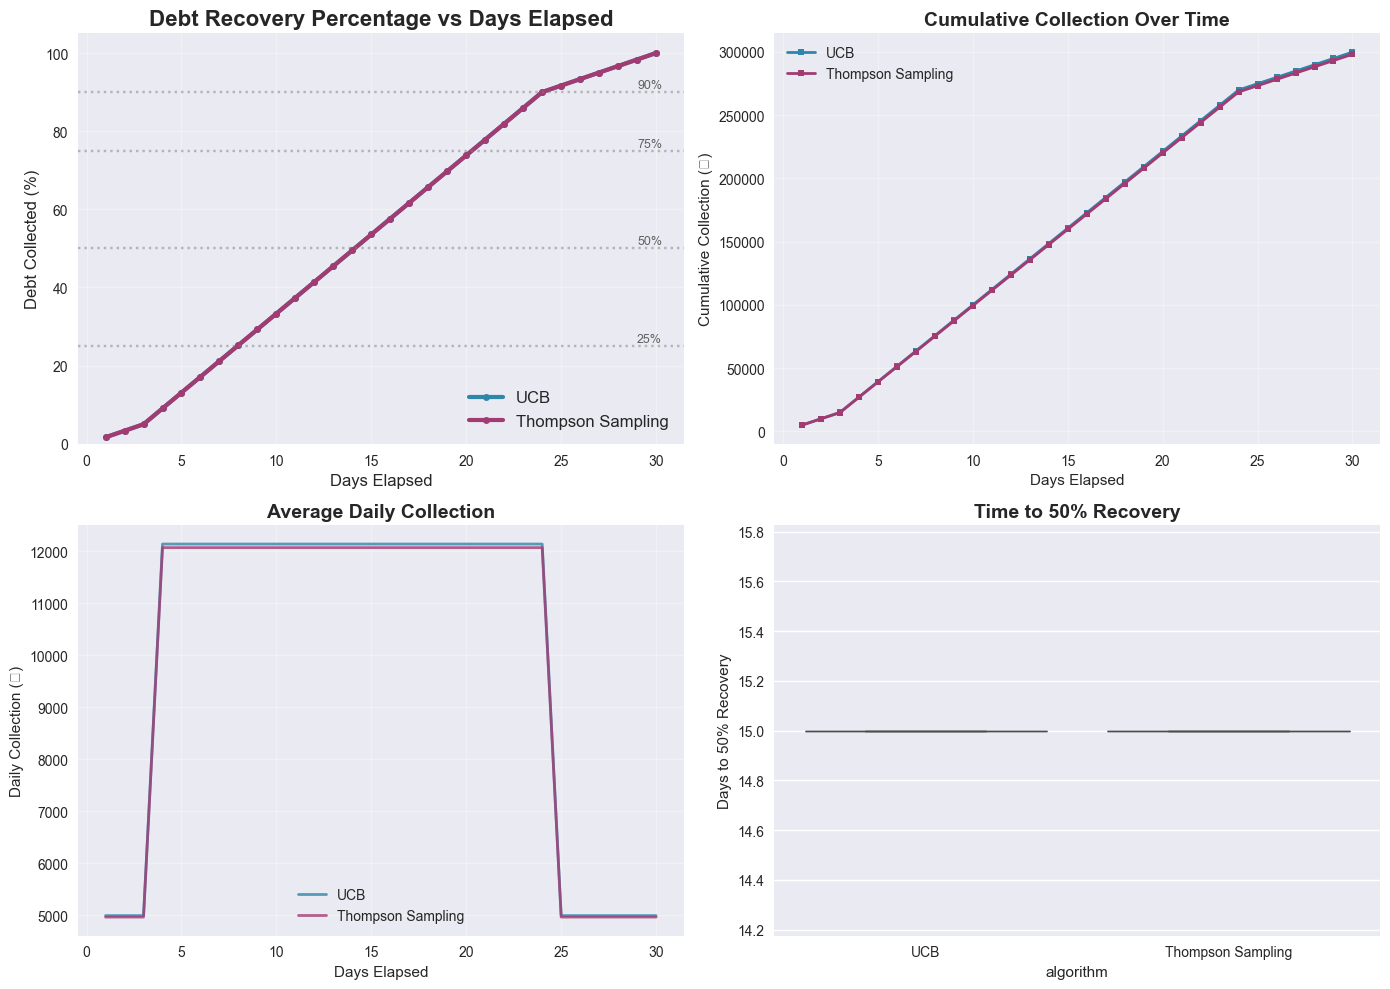


DEBT RECOVERY ANALYSIS SUMMARY

Original Results Summary:
UCB Average Collection: ₹299,860.43
Thompson Average Collection: $298,165.24
Winner: UCB

Recovery Speed Analysis:
UCB: Average final recovery = 100.0%
Thompson Sampling: Average final recovery = 100.0%

RECOVERY MILESTONE ANALYSIS

Time to 10% Recovery:
-------------------------
  UCB: 5.0 ± 0.0 days (1000 runs reached)
  Thompson Sampling: 5.0 ± 0.0 days (1000 runs reached)

Time to 25% Recovery:
-------------------------
  UCB: 8.0 ± 0.0 days (1000 runs reached)
  Thompson Sampling: 8.0 ± 0.0 days (1000 runs reached)

Time to 50% Recovery:
-------------------------
  UCB: 15.0 ± 0.0 days (1000 runs reached)
  Thompson Sampling: 15.0 ± 0.0 days (1000 runs reached)

Time to 75% Recovery:
-------------------------
  UCB: 21.0 ± 0.0 days (1000 runs reached)
  Thompson Sampling: 21.0 ± 0.0 days (1000 runs reached)

Time to 90% Recovery:
-------------------------
  UCB: 24.0 ± 0.0 days (1000 runs reached)
  Thompson Sampling: 24.0

In [388]:
timeseries_df, milestone_analysis = create_debt_recovery_graph_from_existing_results(comparison_results)
